# Sentiment Analysis test

In [741]:
%load_ext autoreload
%autoreload 2
import sys
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
sys.path.append("../../Code")
import matplotlib.pyplot as plt
import opinion_lexicon as op
import afinns as af
import vader
import s140
import so_cal as sc
import utils
import analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [742]:
pd.options.display.max_colwidth = 600
pd.options.display.max_columns = 50

## Load Data with overall scores from tools

In [743]:
reviews = pd.read_csv('interrater_uq2.csv', index_col=0)

In [744]:
len(reviews)

70

In [745]:
norm_reviews = pd.read_csv('../7/reviews_normalisations.csv', index_col=0)

In [746]:
result_set = norm_reviews[norm_reviews['id'].isin(reviews['id'])]

In [747]:
result_set = result_set.join(reviews[['id','interrater_weighted_avg']].set_index('id'), on='id')

In [748]:
result_set.is_copy = False
result_set['interrater'] = result_set['interrater_weighted_avg']/5

In [749]:
result_set = result_set.drop('interrater_weighted_avg', axis=1)

In [750]:
len(result_set)

52

In [773]:
sent_norm_tools = ['afinn_norm_s', 'vader_norm_s', 's140_norm_s', 'so_cal_norm_s', 'op_bow_norm_s', 'op_freq_norm_s']
sent_adj_tools = ['afinn_norm_clipi_s', 'vader_norm_clipi_s', 'so_cal_norm_clipi_s', 'op_bow_norm_clipi_s','op_freq_norm_clipi_s']
whole_norm_tools = ['afinn_norm_o', 'vader_norm_o', 's140_norm_o', 'so_cal_norm_o','op_bow_norm_o', 'op_freq_norm_o']
whole_adj_tools = ['afinn_norm_clipo_o', 'vader_norm_clipo_o', 'so_cal_norm_clipo_o', 'op_bow_norm_clipo_o', 'op_freq_norm_clipo_o']
sent_tools = sent_norm_tools + sent_adj_tools
whole_tools = whole_norm_tools + whole_adj_tools

In [755]:
sentence_set = norm_reviews[norm_reviews['id'].isin(reviews['id'])][['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated']+ sent_tools]

In [756]:
result_set = reduce_sentence_scores(result_set, sent_tools, True)

In [757]:
result_set['interrater'] = result_set['interrater'].astype(float)

# Calculate Error

In [761]:
for a in whole_tools+sent_tools:
    print("Error for %s : %.2f" % (a, analysis.rss(result_set, 'interrater', a)))
    
    

Error for afinn_norm_o : 7.21
Error for vader_norm_o : 4.14
Error for s140_norm_o : 7.89
Error for so_cal_norm_o : 3.95
Error for op_bow_norm_o : 3.00
Error for op_freq_norm_o : 5.35
Error for afinn_norm_clipo_o : 3.70
Error for vader_norm_clipo_o : 3.23
Error for so_cal_norm_clipo_o : 7.72
Error for op_bow_norm_clipo_o : 7.60
Error for op_freq_norm_clipo_o : 7.67
Error for afinn_norm_s : 9.03
Error for vader_norm_s : 2.02
Error for s140_norm_s : 5.42
Error for so_cal_norm_s : 9.78
Error for op_bow_norm_s : 3.83
Error for op_freq_norm_s : 4.65
Error for afinn_norm_clipi_s : 5.05
Error for vader_norm_clipi_s : 2.15
Error for so_cal_norm_clipi_s : 5.36
Error for op_bow_norm_clipi_s : 5.53
Error for op_freq_norm_clipi_s : 5.73


# Split into Levels for further evaluation

In [781]:
overall_lvl_tbl_3 = analysis.build_levels_table(result_set, set(whole_tools).union(['interrater']), 2)

In [782]:
overall_lvl_tbl_5 = analysis.build_levels_table(result_set, set(whole_tools).union(['interrater']), 1)

In [783]:
result_set[sent_tools] = result_set[sent_tools].astype(float)

In [792]:
sentence_lvl_tbl_3 = analysis.build_levels_table(result_set, set(sent_tools).union(['interrater']), 2)

In [793]:
sentence_lvl_tbl_5 = analysis.build_levels_table(result_set, set(sent_tools).union(['interrater']), 1)

# Confusion Matrix

### Overall Confusion Matrices

#### 3-point Scale

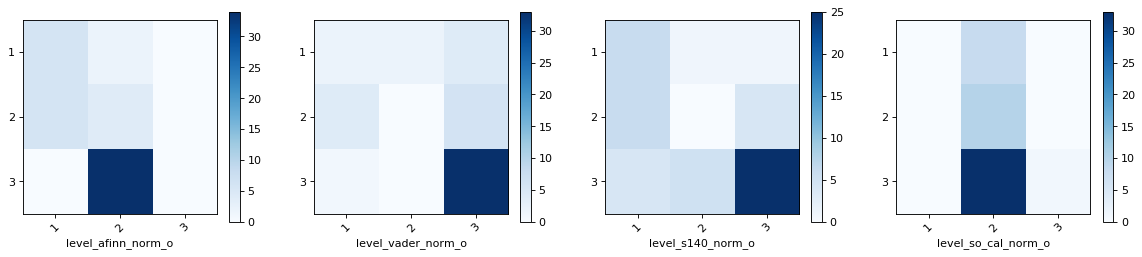

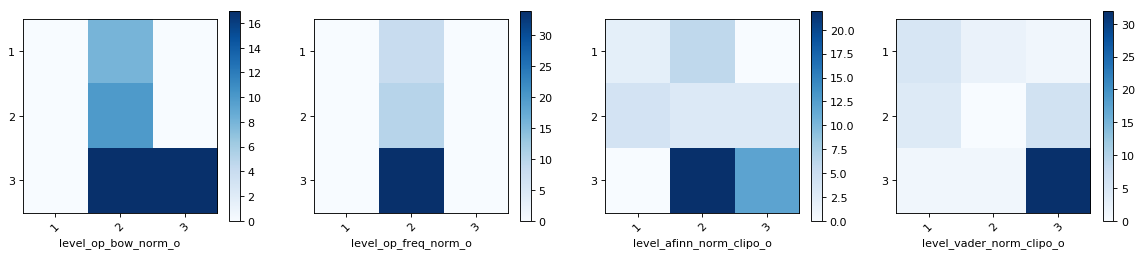

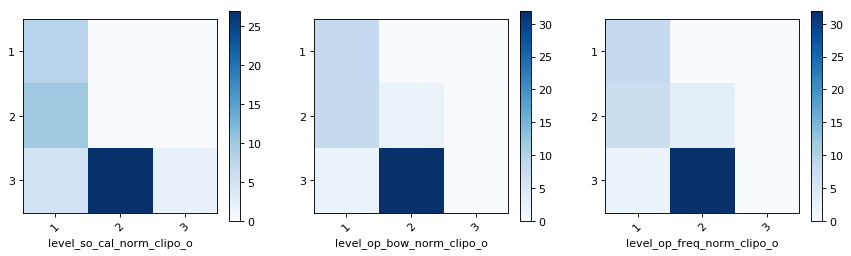

In [786]:
analysis.plot_confusion_matrix_grid(overall_lvl_tbl_3, 'level_interrater', ['level_' + t for t in whole_tools])

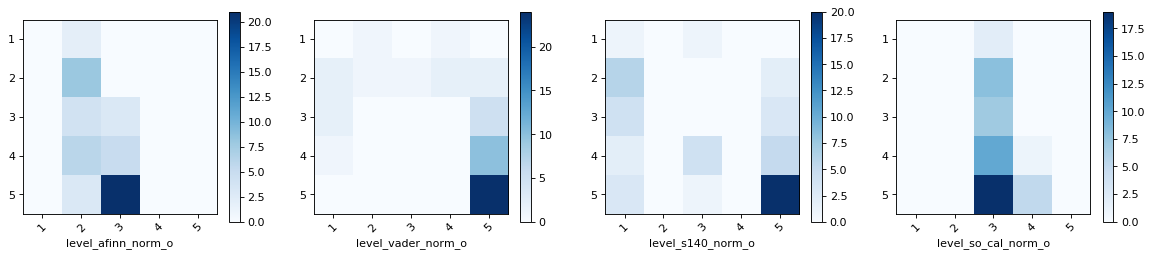

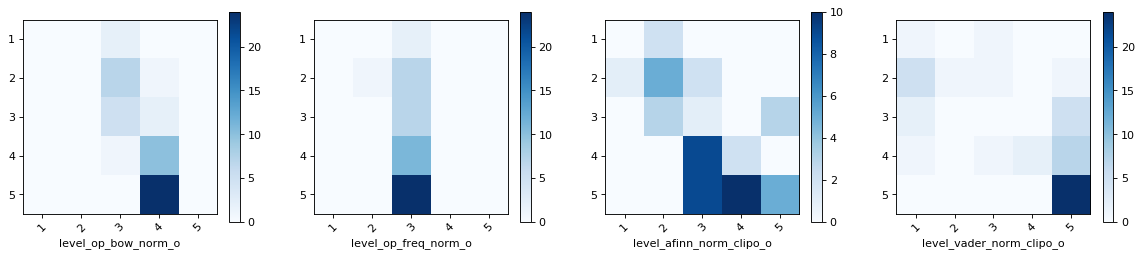

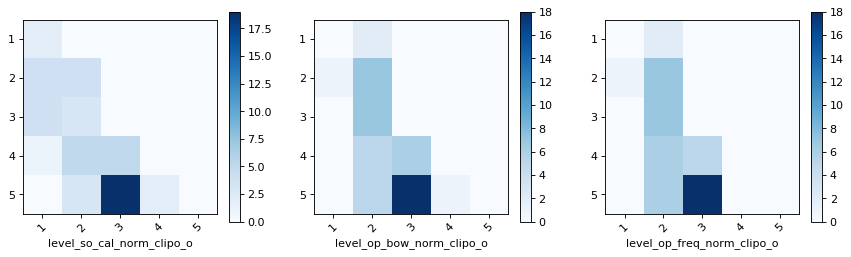

In [787]:
analysis.plot_confusion_matrix_grid(overall_lvl_tbl_5, 'level_interrater', ['level_' + t for t in whole_tools])

### Sentence Tools

#### 3-Point Scale 

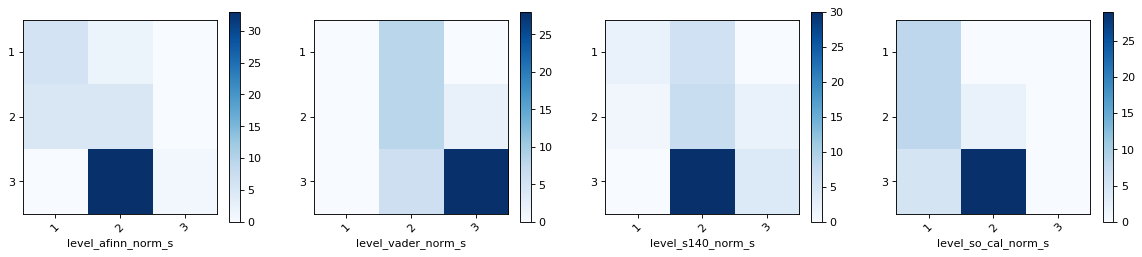

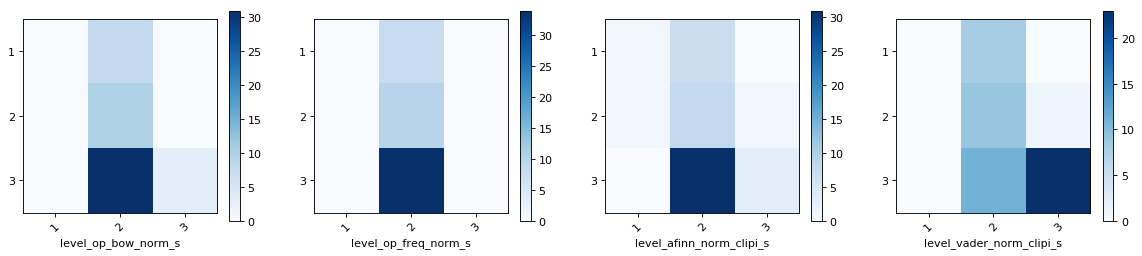

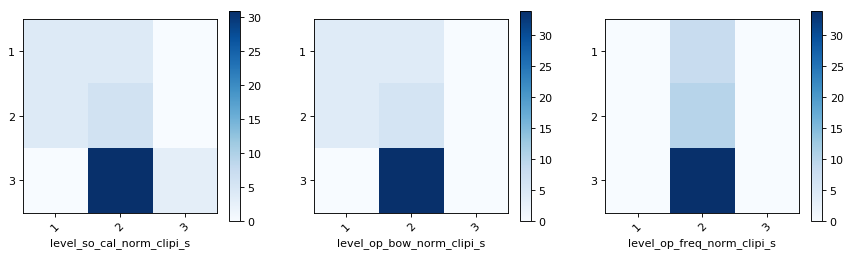

In [794]:
analysis.plot_confusion_matrix_grid(sentence_lvl_tbl_3, 'level_interrater', ['level_' + t for t in sent_tools])

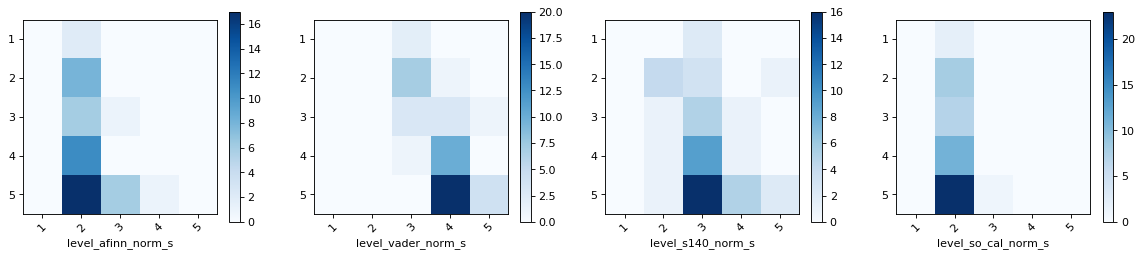

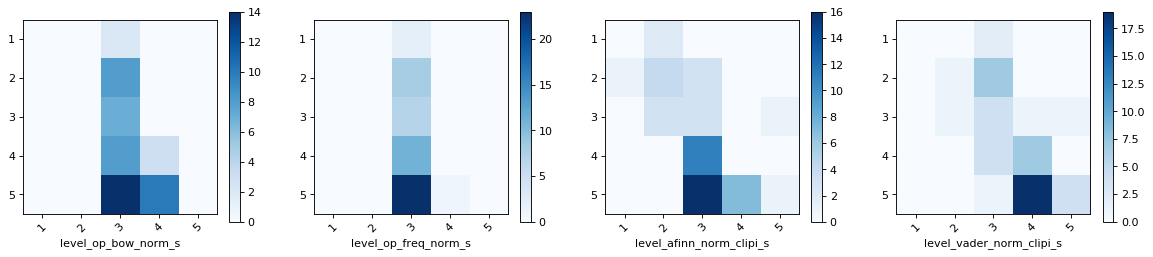

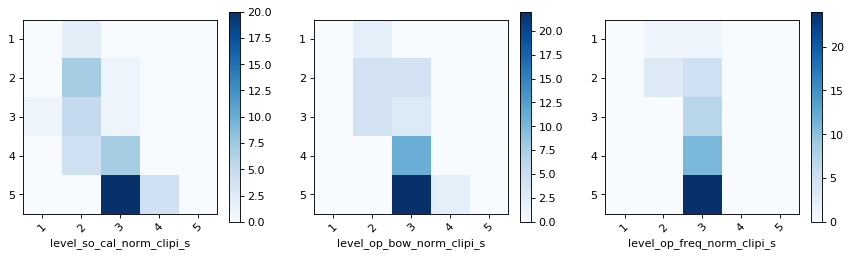

In [795]:
analysis.plot_confusion_matrix_grid(sentence_lvl_tbl_5, 'level_interrater', ['level_' + t for t in sent_tools])

# Averaging

In [864]:
whole_avgs_norm = list(set(whole_norm_tools) - set(['op_freq_norm_o']))
whole_avgs_adj = list(set(whole_adj_tools) - set(['op_freq_norm_clipo_o']))
whole_avgs_best = ['afinn_norm_clipo_o','vader_norm_clipo_o','s140_norm_o', 'so_cal_norm_clipo_o', 'op_bow_norm_o']
sent_avgs_norm = list(set(sent_norm_tools) - set(['op_freq_norm_s']))
sent_avgs_adj = list(set(sent_adj_tools) - set(['op_freq_norm_clipi_s']))
sent_avgs_best = ['afinn_norm_clipi_s','vader_norm_s','s140_norm_s', 'so_cal_norm_clipi_s', 'op_bow_norm_s']
best_of_each = ['afinn_norm_clipo_o','vader_norm_s','s140_norm_s', 'so_cal_norm_o', 'op_bow_norm_o']
match_1 = list(set(whole_avgs_best) - set(['s140_norm_o']))
match_2 = list(set(sent_avgs_best) - set(['s140_norm_s']))
match_3 = list(set(best_of_each) - set(['s140_norm_s']))
match_4 = ['vader_norm_clipo_o', 'vader_norm_s']
match_5 = ['afinn_norm_clipo_o', 'afinn_norm_clipi_s']
match_6 = match_4 + match_5
match_7 = match_6 + ['so_cal_norm_clipi_s']
match_8 = match_4 + ['afinn_norm_clipo_o']
match_9 = match_6 + ['s140_norm_s']
match_10 = match_6 + ['so_cal_norm_clipo_o']
match_11 = match_4 + ['so_cal_norm_clipo_o']
match_12 = ['vader_norm_clipo_o', 'afinn_norm_clipo_o']
match_13 = match_12 + ['so_cal_norm_clipo_o']

In [865]:
avg_table = result_set[['id','comments',  'token_len', 'num_of_sents', 'google_langs', 'interrater']]
avg_sent_table = result_set[['id','comments',  'token_len', 'num_of_sents', 'google_langs', 'interrater']]
avg_sent_table.is_copy = False
avg_table.is_copy = False

In [866]:
avg_sent_table['sent_avgs_norm'] = [np.sum(r[sent_avgs_norm])/len(sent_avgs_norm) for _, r in sentence_set.iterrows()]
avg_sent_table['sent_avgs_adj'] = [np.sum(r[sent_avgs_adj])/len(sent_avgs_adj) for _, r in sentence_set.iterrows()]
avg_sent_table['sent_avgs_best'] = [np.sum(r[sent_avgs_best])/len(sent_avgs_best) for _, r in sentence_set.iterrows()]

In [867]:
avg_table['avg_whole_norm'] = np.sum(result_set[whole_avgs_norm], axis=1)/5
avg_table['avg_whole_adj'] = np.sum(result_set[whole_avgs_adj], axis=1)/4
avg_table['avg_whole_best'] = np.sum(result_set[whole_avgs_best], axis=1)/5
avg_table['avg_best_of_each'] = np.sum(result_set[best_of_each], axis=1)/5

In [868]:
avg_table['avg_sent_norm'] = reduce_to_average(avg_sent_table['sent_avgs_norm'])
avg_table['avg_sent_adj'] = reduce_to_average(avg_sent_table['sent_avgs_adj'])
avg_table['avg_sent_best'] = reduce_to_average(avg_sent_table['sent_avgs_best'])

In [869]:
avg_table['avg_match_1'] = np.sum(result_set[match_1], axis=1)/len(match_1)
avg_table['avg_match_2'] = np.sum(result_set[match_2], axis=1)/len(match_2)
avg_table['avg_match_3'] = np.sum(result_set[match_3], axis=1)/len(match_3)
avg_table['avg_match_4'] = np.sum(result_set[match_4], axis=1)/len(match_4)
avg_table['avg_match_5'] = np.sum(result_set[match_5], axis=1)/len(match_5)
avg_table['avg_match_6'] = np.sum(result_set[match_6], axis=1)/len(match_6)
avg_table['avg_match_7'] = np.sum(result_set[match_7], axis=1)/len(match_7)
avg_table['avg_match_8'] = np.sum(result_set[match_8], axis=1)/len(match_8)
avg_table['avg_match_9'] = np.sum(result_set[match_9], axis=1)/len(match_9)
avg_table['avg_match_10'] = np.sum(result_set[match_10], axis=1)/len(match_10)
avg_table['avg_match_11'] = np.sum(result_set[match_11], axis=1)/len(match_11)
avg_table['avg_match_12'] = np.sum(result_set[match_12], axis=1)/len(match_12)
avg_table['avg_match_13'] = np.sum(result_set[match_13], axis=1)/len(match_13)

In [870]:
avg_tools = ['avg_match_1','avg_match_2','avg_match_3','avg_match_4','avg_match_5','avg_match_6','avg_match_7',
             'avg_match_8','avg_match_9','avg_match_10','avg_match_11','avg_match_12','avg_match_13','avg_sent_norm','avg_sent_adj','avg_sent_best','avg_whole_norm','avg_whole_adj','avg_whole_best', 'avg_best_of_each']


In [871]:
avg_table[avg_tools] = avg_table[avg_tools].astype(float)

### Error

In [872]:
for a in avg_tools:
    print("Error for %s : %.2f" % (a, analysis.rss(avg_table, 'interrater', a)))

Error for avg_match_1 : 2.41
Error for avg_match_2 : 3.59
Error for avg_match_3 : 2.76
Error for avg_match_4 : 1.57
Error for avg_match_5 : 4.05
Error for avg_match_6 : 2.13
Error for avg_match_7 : 2.46
Error for avg_match_8 : 1.74
Error for avg_match_9 : 2.43
Error for avg_match_10 : 2.61
Error for avg_match_11 : 2.06
Error for avg_match_12 : 2.13
Error for avg_match_13 : 2.73
Error for avg_sent_norm : 5.10
Error for avg_sent_adj : 4.09
Error for avg_sent_best : 3.80
Error for avg_whole_norm : 2.39
Error for avg_whole_adj : 3.44
Error for avg_whole_best : 2.33
Error for avg_best_of_each : 3.09


### 3 point scale

In [873]:
avg_lvl_tbl_3 = analysis.build_levels_table(avg_table, set(avg_tools).union(['interrater']), 2)

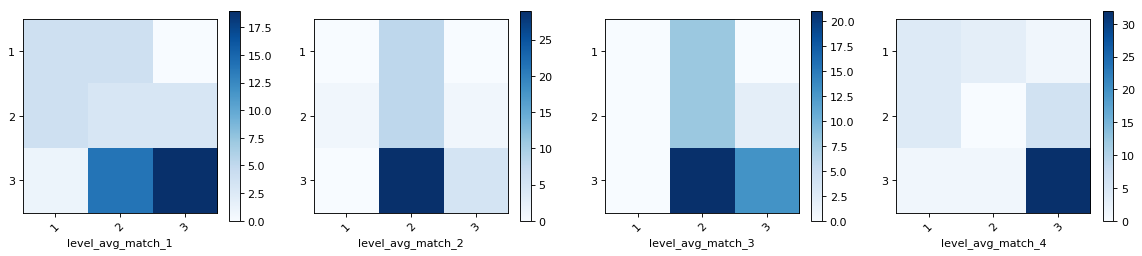

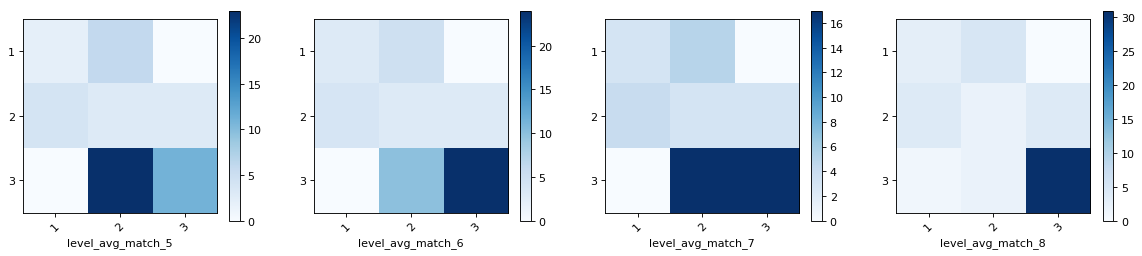

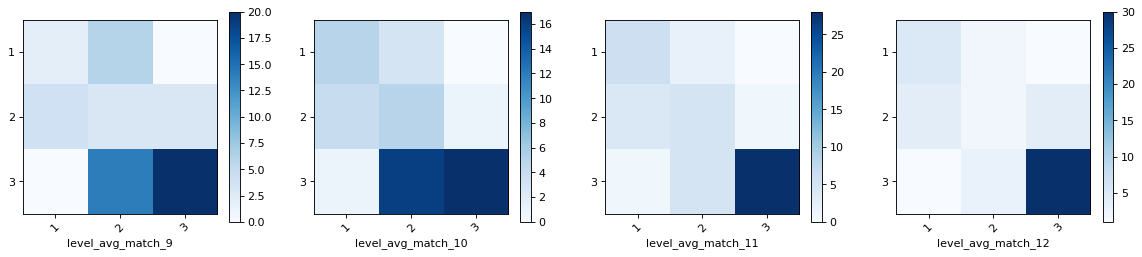

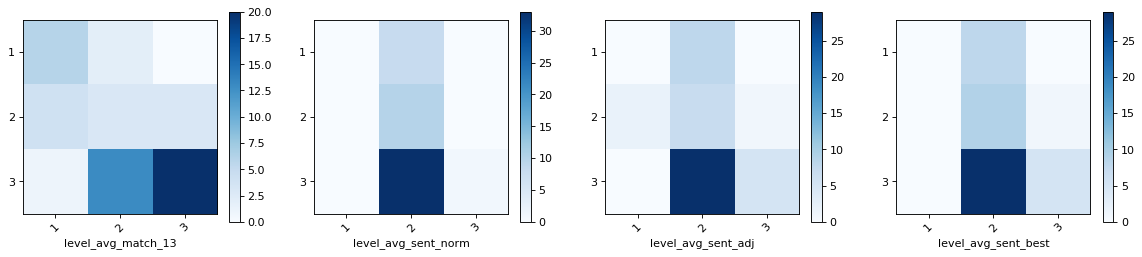

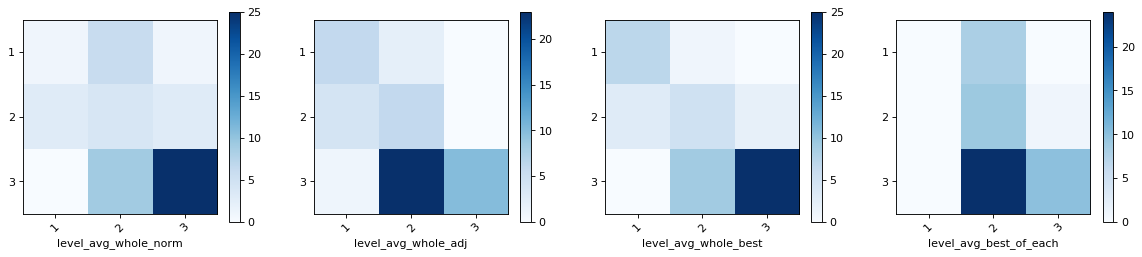

In [874]:
analysis.plot_confusion_matrix_grid(avg_lvl_tbl_3, 'level_interrater', ['level_' + t for t in avg_tools])

### 5-point Scale

In [875]:
avg_lvl_tbl_5 = analysis.build_levels_table(avg_table, set(avg_tools).union(['interrater']), 1)

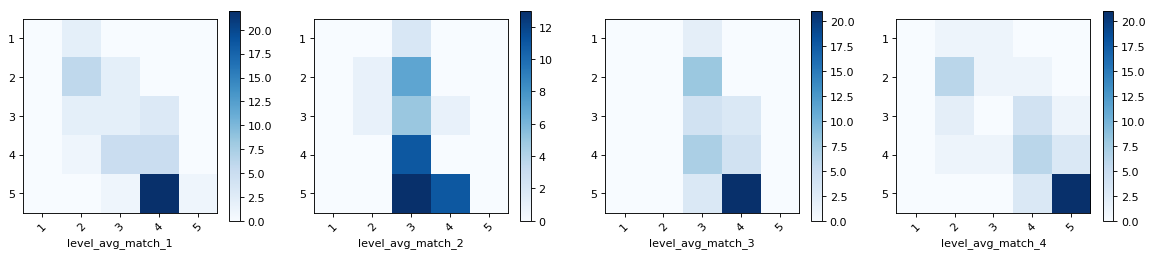

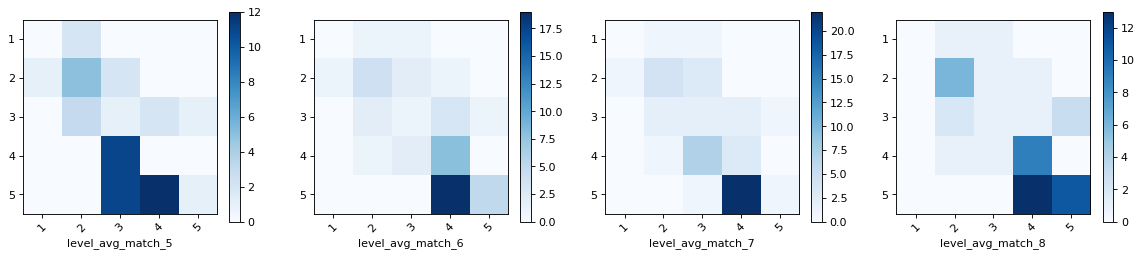

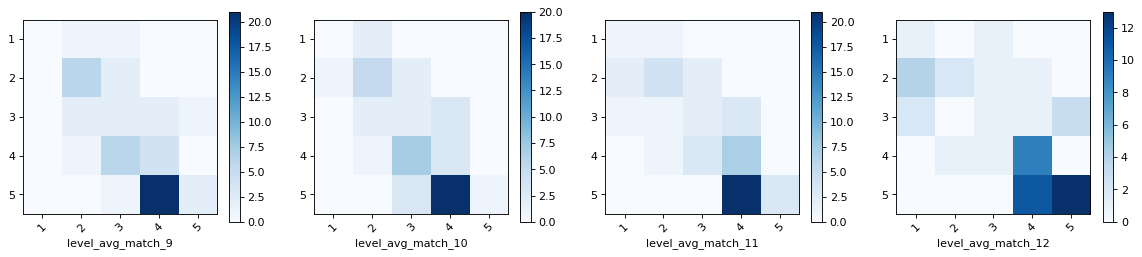

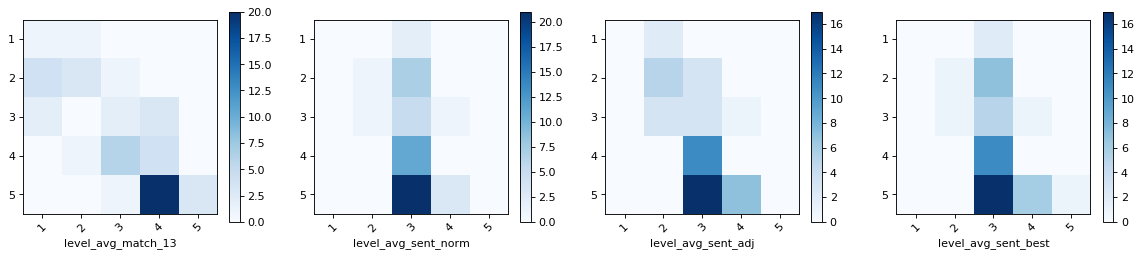

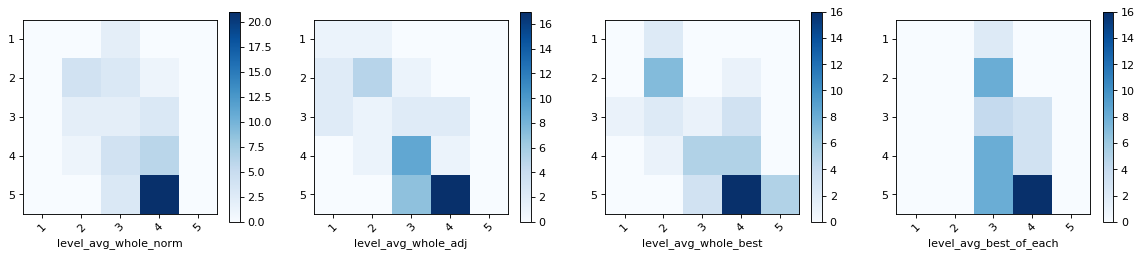

In [876]:
analysis.plot_confusion_matrix_grid(avg_lvl_tbl_5, 'level_interrater', ['level_' + t for t in avg_tools])

In [896]:
avg_lvl_tbl_5[avg_lvl_tbl_5['level_avg_whole_best'] == 1]

,id,comments,level_avg_match_7,level_avg_match_8,level_avg_sent_adj,level_avg_whole_norm,level_avg_match_12,level_avg_sent_norm,level_avg_match_11,level_avg_match_13,level_avg_match_10,level_avg_whole_adj,level_avg_match_9,level_avg_match_6,level_avg_match_4,level_interrater,level_avg_sent_best,level_avg_match_2,level_avg_whole_best,level_avg_match_1,level_avg_match_5,level_avg_best_of_each,level_avg_match_3
123795,48522888,Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !,2,2,2,2,1,2,1,1,2,1,2,2,2,3,2,2,1,2,2,3,3


In [823]:
analysis.full_evaluation_table(analysis.create_confusion_matrix(avg_lvl_tbl_3['level_interrater'], avg_lvl_tbl_3['level_avg_match_4']))

,Label,Gold,Guess,Precision,Recall,F1
0,1,8,9,0.444444,0.500000,0.470588
1,2,10,4,0.000000,0.000000,0.000000
2,3,34,39,0.820513,0.941176,0.876712
3,[All],52,52,0.692308,0.692308,0.692308


In [824]:
analysis.full_evaluation_table(analysis.create_confusion_matrix(avg_lvl_tbl_3['level_interrater'], avg_lvl_tbl_3['level_avg_whole_best']))

,Label,Gold,Guess,Precision,Recall,F1
0,1,8,10,0.700000,0.875000,0.777778
1,2,10,15,0.333333,0.500000,0.400000
2,3,34,27,0.925926,0.735294,0.819672
3,[All],52,52,0.711538,0.711538,0.711538


In [888]:
analysis.full_evaluation_table(analysis.create_confusion_matrix(avg_lvl_tbl_3['level_interrater'], avg_lvl_tbl_3['level_avg_match_11']))

,Label,Gold,Guess,Precision,Recall,F1
0,1,8,11,0.545455,0.750000,0.631579
1,2,10,12,0.416667,0.500000,0.454545
2,3,34,29,0.965517,0.823529,0.888889
3,[All],52,52,0.750000,0.750000,0.750000


In [826]:
analysis.full_evaluation_table(analysis.create_confusion_matrix(avg_lvl_tbl_5['level_interrater'], avg_lvl_tbl_5['level_avg_match_4']))

,Label,Gold,Guess,Precision,Recall,F1
0,1,2,0,0.000000,0.000000,0.000000
1,2,8,10,0.600000,0.750000,0.666667
2,3,7,3,0.000000,0.000000,0.000000
3,4,11,14,0.428571,0.545455,0.480000
4,5,24,25,0.840000,0.875000,0.857143
5,[All],52,52,0.634615,0.634615,0.634615


In [887]:
analysis.full_evaluation_table(analysis.create_confusion_matrix(avg_lvl_tbl_5['level_interrater'], avg_lvl_tbl_5['level_avg_match_11']))

,Label,Gold,Guess,Precision,Recall,F1
0,1,2,4,0.250000,0.500000,0.333333
1,2,8,7,0.571429,0.500000,0.533333
2,3,7,7,0.285714,0.285714,0.285714
3,4,11,31,0.225806,0.636364,0.333333
4,5,24,3,1.000000,0.125000,0.222222
5,[All],52,52,0.326923,0.326923,0.326923


# Test on all lengths

In [907]:
int_reviews = pd.read_csv('interrater_all.csv', index_col=0)

In [908]:
int_result_set = norm_reviews[norm_reviews['id'].isin(int_reviews['id'])]

In [912]:
int_result_set = int_result_set.join(int_reviews[['id','interrater']].set_index('id'), on='id')

In [913]:
int_result_set.is_copy = False
int_result_set['interrater'] = int_result_set['interrater']/5

In [773]:
sent_norm_tools = ['afinn_norm_s', 'vader_norm_s', 's140_norm_s', 'so_cal_norm_s', 'op_bow_norm_s', 'op_freq_norm_s']
sent_adj_tools = ['afinn_norm_clipi_s', 'vader_norm_clipi_s', 'so_cal_norm_clipi_s', 'op_bow_norm_clipi_s','op_freq_norm_clipi_s']
whole_norm_tools = ['afinn_norm_o', 'vader_norm_o', 's140_norm_o', 'so_cal_norm_o','op_bow_norm_o', 'op_freq_norm_o']
whole_adj_tools = ['afinn_norm_clipo_o', 'vader_norm_clipo_o', 'so_cal_norm_clipo_o', 'op_bow_norm_clipo_o', 'op_freq_norm_clipo_o']
sent_tools = sent_norm_tools + sent_adj_tools
whole_tools = whole_norm_tools + whole_adj_tools

In [916]:
int_sentence_set = norm_reviews[norm_reviews['id'].isin(int_result_set['id'])][['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated']+ sent_tools]

In [917]:
int_result_set = reduce_sentence_scores(int_result_set, sent_tools, True)

In [918]:
int_result_set['interrater'] = int_result_set['interrater'].astype(float)

In [920]:
for a in whole_tools+sent_tools:
    print("Error for %s : %.2f" % (a, analysis.rss(int_result_set, 'interrater', a)))

Error for afinn_norm_o : 7.77
Error for vader_norm_o : 0.60
Error for s140_norm_o : 2.28
Error for so_cal_norm_o : 2.92
Error for op_bow_norm_o : 1.62
Error for op_freq_norm_o : 4.00
Error for afinn_norm_clipo_o : 4.50
Error for vader_norm_clipo_o : 2.36
Error for so_cal_norm_clipo_o : 4.74
Error for op_bow_norm_clipo_o : 5.26
Error for op_freq_norm_clipo_o : 4.98
Error for afinn_norm_s : 7.98
Error for vader_norm_s : 0.96
Error for s140_norm_s : 3.47
Error for so_cal_norm_s : 8.88
Error for op_bow_norm_s : 2.59
Error for op_freq_norm_s : 3.47
Error for afinn_norm_clipi_s : 3.48
Error for vader_norm_clipi_s : 1.16
Error for so_cal_norm_clipi_s : 3.74
Error for op_bow_norm_clipi_s : 4.02
Error for op_freq_norm_clipi_s : 4.39


In [931]:
int_avg_table = int_result_set[['id','comments',  'token_len', 'num_of_sents', 'google_langs', 'interrater']]
int_avg_sent_table = int_result_set[['id','comments',  'token_len', 'num_of_sents', 'google_langs', 'interrater']]
int_avg_sent_table.is_copy = False
int_avg_table.is_copy = False

In [933]:
int_avg_table['avg_whole_norm'] = np.sum(int_result_set[whole_avgs_norm], axis=1)/5
int_avg_table['avg_whole_adj'] = np.sum(int_result_set[whole_avgs_adj], axis=1)/4
int_avg_table['avg_whole_best'] = np.sum(int_result_set[whole_avgs_best], axis=1)/5
int_avg_table['avg_best_of_each'] = np.sum(int_result_set[best_of_each], axis=1)/5

In [934]:
int_avg_table['avg_match_4'] = np.sum(int_result_set[match_4], axis=1)/len(match_4)
int_avg_table['avg_match_7'] = np.sum(int_result_set[match_7], axis=1)/len(match_7)
int_avg_table['avg_match_8'] = np.sum(int_result_set[match_8], axis=1)/len(match_8)
int_avg_table['avg_match_11'] = np.sum(int_result_set[match_11], axis=1)/len(match_11)
int_avg_table['avg_match_12'] = np.sum(int_result_set[match_12], axis=1)/len(match_12)

In [935]:
int_avg_tools = ['avg_match_4','avg_match_7','avg_match_8','avg_match_11','avg_match_12','avg_whole_norm','avg_whole_adj','avg_whole_best', 'avg_best_of_each']


In [936]:
int_avg_table[int_avg_tools] = int_avg_table[int_avg_tools].astype(float)

In [937]:
int_avg_table

,id,comments,token_len,num_of_sents,google_langs,interrater,avg_whole_norm,avg_whole_adj,avg_whole_best,avg_best_of_each,avg_match_4,avg_match_7,avg_match_8,avg_match_11,avg_match_12
5158,61606,"Marieka is very gracious sweet host :) , her place is safe clean and cozy, I really enjoyed my stay ,and location is close everything you may want to visit in NY city Manhattan , I would definitely stay here again , and I highly recommend Marieka's place to anyone visiting NY,",48,1,en,0.934,0.635552,0.635781,0.640213,0.368997,0.472846,0.300313,0.500522,0.480215,0.750782
17398,223591142,We had a fantastic stay! Greg is a great host. He was really helpful and left us to our own privacy but was also very friendly when we did see him. The room is a great size and nice and cosy! The apartment is in a nice quiet area and very close to subway. Took around 30minutes to travel to central Manhattan. Would definitely recommend for somewhere a little quieter but easy to get to the busy city! :),78,8,en,0.880,0.751664,0.681660,0.779164,0.398436,0.490385,0.337766,0.562943,0.497725,0.844414
24652,8201629,"Goldi has an amazing house (house!) in New York, and I'd suggest staying there to anyone who has the opportunity. I left a luxury hotel that my job was footing the bill for to stay somewhere more unique and less ""scene-y"" and this was the perfect alternative. For a true city experience in a whimsical setting, stay here. And enjoy the cats - they're all very affectionate and there's no litter box to clean. Five stars.",76,6,en,0.900,0.735105,0.640500,0.754277,0.378642,0.462790,0.311694,0.519489,0.493177,0.779234
27964,200221708,Cindy was a good host. The location was near the subway and the neighborhood was safe. You have bars and restaurants very near the house. Recommended.,26,4,en,0.866,0.579380,0.474337,0.511985,0.336777,0.249690,0.182334,0.303890,0.315731,0.455835
35391,1335679,"just got back from a weeks stay at reginas. upon first contacting her she responded immediately and was very accommodating about leaving bags before check in and check out times, that's a big thing it was my first airb&b experience but i felt secure booking with regina. the room is as pictured ... initially i was a bit sceptical about the bed, thinking it was a bit firm and not too comfortable. but, i slept well the whole time with no back ache ... and i have big problems with both my back and beds in general. the private bathroom has great pressure in the shower. regina is very quiet, w...",211,10,en,0.920,0.702350,0.533280,0.678729,0.336901,0.447460,0.283890,0.473149,0.418491,0.709724
72969,62198130,"Irene was a warmly welcoming, friendly host. I very much enjoyed my stay in her lovely home, and would certainly visit again.",22,2,en,0.840,0.725090,0.608210,0.713353,0.348695,0.450783,0.266027,0.443379,0.470789,0.665069
78216,234401676,"A clean comfortable and airy apartment with good living space, a well appointed kitchen and in a brilliant location, just minutes away from the buzz of Soho",27,1,en,0.834,0.723533,0.598544,0.705147,0.359082,0.422478,0.267565,0.445942,0.434981,0.668913
84713,239174122,"Very nice place, awesome location and great host!!!",8,2,en,0.920,0.746131,0.674241,0.747776,0.380905,0.417124,0.262233,0.437055,0.484868,0.655583
87098,171414495,"We had a wonderful time, location was great, a lot of restaurants close by. Within walking distance Broadway Shows and MOMA! Comfy beds, very nice accommodations! Great value!❤️❤️❤️",28,4,en,1.000,0.732854,0.641537,0.748539,0.367424,0.447349,0.283845,0.473076,0.510037,0.709614
89612,134844111,Mike was great host! His apartment is in a perfect location for walking and also using public transit. It was fun getting to know a true Manhattanite! He was hospitable to my whole crew and we were grateful. We recommend!,40,5,en,0.934,0.750435,0.695545,0.785392,0.389284,0.461229,0.301873,0.503122,0.541281,0.754683


In [938]:
for a in int_avg_tools:
    print("Error for %s : %.2f" % (a, analysis.rss(int_avg_table, 'interrater', a)))

Error for avg_match_4 : 8.67
Error for avg_match_7 : 13.12
Error for avg_match_8 : 6.99
Error for avg_match_11 : 6.96
Error for avg_match_12 : 2.58
Error for avg_whole_norm : 1.49
Error for avg_whole_adj : 3.11
Error for avg_whole_best : 1.76
Error for avg_best_of_each : 9.15


### 3 point scale

In [939]:
int_avg_lvl_tbl_3 = analysis.build_levels_table(int_avg_table, set(int_avg_tools).union(['interrater']), 2)

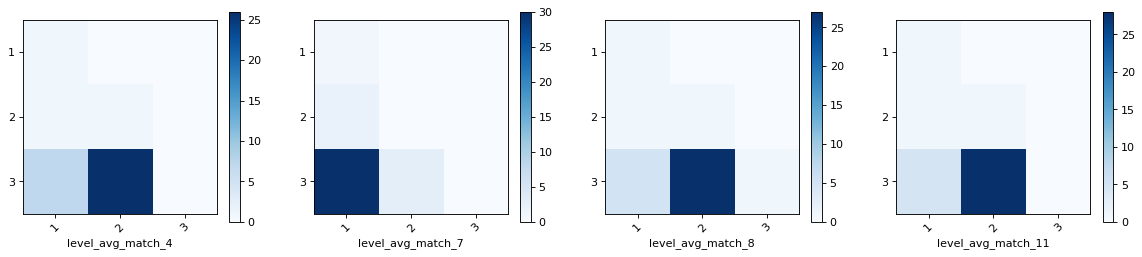

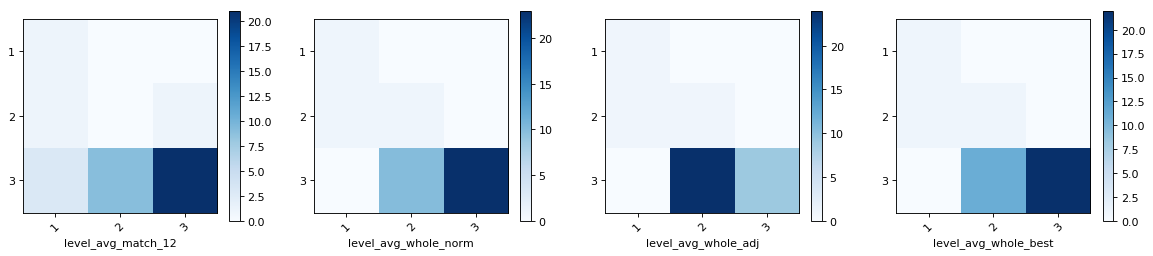

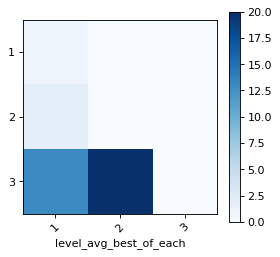

In [940]:
analysis.plot_confusion_matrix_grid(int_avg_lvl_tbl_3, 'level_interrater', ['level_' + t for t in int_avg_tools])

### 5-point Scale

In [942]:
int_avg_lvl_tbl_5 = analysis.build_levels_table(int_avg_table, set(int_avg_tools).union(['interrater']), 1)

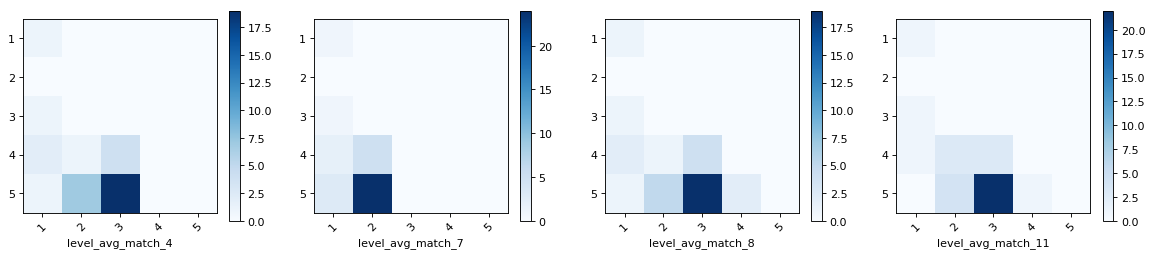

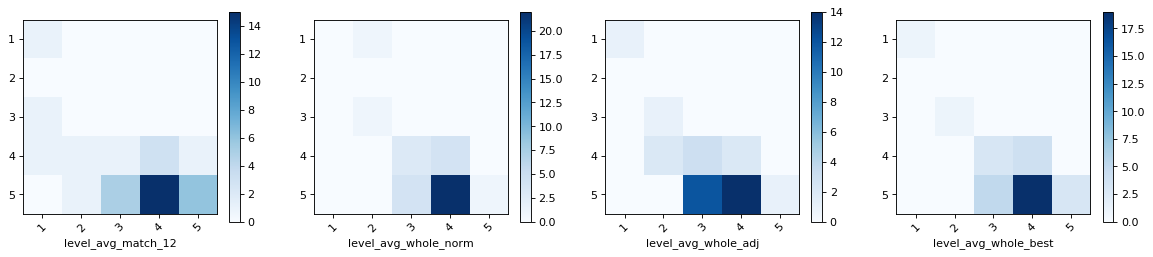

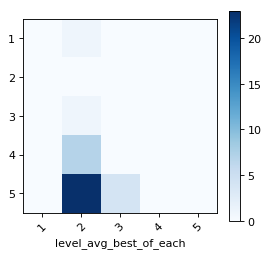

In [943]:
analysis.plot_confusion_matrix_grid(int_avg_lvl_tbl_5, 'level_interrater', ['level_' + t for t in int_avg_tools])

In [944]:
int_avg_lvl_tbl_5

,id,comments,level_avg_match_7,level_avg_match_8,level_avg_whole_norm,level_avg_match_12,level_avg_match_4,level_interrater,level_avg_whole_best,level_avg_match_11,level_avg_best_of_each,level_avg_whole_adj
5158,61606,"Marieka is very gracious sweet host :) , her place is safe clean and cozy, I really enjoyed my stay ,and location is close everything you may want to visit in NY city Manhattan , I would definitely stay here again , and I highly recommend Marieka's place to anyone visiting NY,",2,3,4,4,3,5,4,3,2,4
17398,223591142,We had a fantastic stay! Greg is a great host. He was really helpful and left us to our own privacy but was also very friendly when we did see him. The room is a great size and nice and cosy! The apartment is in a nice quiet area and very close to subway. Took around 30minutes to travel to central Manhattan. Would definitely recommend for somewhere a little quieter but easy to get to the busy city! :),2,3,4,5,3,5,4,3,2,4
24652,8201629,"Goldi has an amazing house (house!) in New York, and I'd suggest staying there to anyone who has the opportunity. I left a luxury hotel that my job was footing the bill for to stay somewhere more unique and less ""scene-y"" and this was the perfect alternative. For a true city experience in a whimsical setting, stay here. And enjoy the cats - they're all very affectionate and there's no litter box to clean. Five stars.",2,3,4,4,3,5,4,3,2,4
27964,200221708,Cindy was a good host. The location was near the subway and the neighborhood was safe. You have bars and restaurants very near the house. Recommended.,1,2,3,3,2,5,3,2,2,3
35391,1335679,"just got back from a weeks stay at reginas. upon first contacting her she responded immediately and was very accommodating about leaving bags before check in and check out times, that's a big thing it was my first airb&b experience but i felt secure booking with regina. the room is as pictured ... initially i was a bit sceptical about the bed, thinking it was a bit firm and not too comfortable. but, i slept well the whole time with no back ache ... and i have big problems with both my back and beds in general. the private bathroom has great pressure in the shower. regina is very quiet, w...",2,3,4,4,3,5,4,3,2,3
72969,62198130,"Irene was a warmly welcoming, friendly host. I very much enjoyed my stay in her lovely home, and would certainly visit again.",2,3,4,4,3,5,4,3,2,4
78216,234401676,"A clean comfortable and airy apartment with good living space, a well appointed kitchen and in a brilliant location, just minutes away from the buzz of Soho",2,3,4,4,3,5,4,3,2,3
84713,239174122,"Very nice place, awesome location and great host!!!",2,3,4,4,3,5,4,3,2,4
87098,171414495,"We had a wonderful time, location was great, a lot of restaurants close by. Within walking distance Broadway Shows and MOMA! Comfy beds, very nice accommodations! Great value!❤️❤️❤️",2,3,4,4,3,5,4,3,2,4
89612,134844111,Mike was great host! His apartment is in a perfect location for walking and also using public transit. It was fun getting to know a true Manhattanite! He was hospitable to my whole crew and we were grateful. We recommend!,2,3,4,4,3,5,4,3,2,4


# Analyse sentences

In [945]:
analyse_review (txt, scores, 2)

In [613]:
s_out ={}
for i,r in sentence_set.iterrows():
    s_out[r['id']] = {}
    for t in sent_tools:
        print(r['id'], " :", t)
        display_html(analyse_review (r['comments'], str_to_list(r[t]) if type(r[t]) == str else r[t], 1))

23272403  : Vader-sentence-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : Vader-sentence-adj-1-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : Vader-sentence-adj-2-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : s140-sentence-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_bow-sentence-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_bow-sentence-adj-1-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_bow-sentence-adj-2-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_freq-sentence-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_freq-sentence-adj-1-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : opinion_freq-sentence-adj-2-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : Affin-sentence-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : Affin-sentence-adj-1-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

23272403  : Affin-sentence-adj-2-norm


What a location. Its 5 mins walk to the 2 Av subway station, 10-12 mins walk to Soho and 5 mins walk to Chinatown. This is really ideal if you want to experience the city by day. Reina was very helpful in helping me and I wish I could have known her better due to my busy schedule. She's also very quick with response time, I almost had a panic attack in which I thought I couldn't make it to my booking but she was more than helpful and even advised me on options. All in all, I had a great 14 days with this stay and I would recommend this place to others especially if you want to be part of the action on the LES. ps. Her cat was an awesome host as well!

14809593  : Vader-sentence-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : Vader-sentence-adj-1-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : Vader-sentence-adj-2-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : s140-sentence-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_bow-sentence-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_bow-sentence-adj-1-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_bow-sentence-adj-2-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_freq-sentence-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_freq-sentence-adj-1-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : opinion_freq-sentence-adj-2-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : Affin-sentence-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : Affin-sentence-adj-1-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

14809593  : Affin-sentence-adj-2-norm


This was my 2nd time staying at Ruth's charming studio apartment. The terrace and the location cannot be beat; they are my two favorite things about the apartment that warranted a return visit. The 72nd subway stop is minutes away, and the outdoor space for a cup of coffee in the morning and a glass of wine at night is perfectly lovely. Ruth is always a very gracious host - a nice combination of being helpful and available but not intrusive. :) Thanks, Ruth, for another fabulous stay! I so appreciated the opportunity to return!

26771065  : Vader-sentence-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : Vader-sentence-adj-1-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : Vader-sentence-adj-2-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : s140-sentence-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_bow-sentence-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_bow-sentence-adj-1-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_bow-sentence-adj-2-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_freq-sentence-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_freq-sentence-adj-1-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : opinion_freq-sentence-adj-2-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : Affin-sentence-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : Affin-sentence-adj-1-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

26771065  : Affin-sentence-adj-2-norm


The room was a good size. However it didn't seem that the sheets were clean since I found long female hair in the bed. Also I had an evening appointment and Susan told me that she lost her extra key so she couldn't provide me with my own key. And she would like me to not come home too late since she would have to wait up for me to return so she could let me into the building and the apartment. And if I wanted to come home after 11 pm she wanted me to call her to let her know. And she would prefer that I didn't come home later than 12. It really felt like a curfew and it was annoying since I paid full price and it shouldn't have to be my problem that she couldn't provide me with a key so she didn't have to wait up to let me in. If anything, she should be more accommodating and say that I could come home whenever since it was her fault that I couldn't get my own key. When I asked her about check out she said that she was very flexible with time so I asked if 1.30 or 2 pm would be OK and then she asked me to leave at 12 pm because she had people coming over in the afternoon. So all in all not a very good host.

6048167  : Vader-sentence-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : Vader-sentence-adj-1-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : Vader-sentence-adj-2-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : s140-sentence-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_bow-sentence-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_bow-sentence-adj-1-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_bow-sentence-adj-2-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_freq-sentence-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_freq-sentence-adj-1-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : opinion_freq-sentence-adj-2-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : Affin-sentence-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : Affin-sentence-adj-1-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

6048167  : Affin-sentence-adj-2-norm


We vere a family of four staying in Davids apartment for nine days. It was a perfect place to stay. Near by everything and still quite. New York was very hot at the moment, and the AC functioned. The apartment was spacious. Our two teenagers could very well stay in the smallest bedroom. The apartment is in the 5.floor and had a lot of light. It is charming and reminded me of my student days though a bit more comfortable. The kitchen was ok. We did not make dinner there but breakfast and small meals. The steps can be a problem but it was ok for us. The nighborhood is grate! Lots of nice restaurants in the street. And nice streets for shopping just around the corner. And the subway is five minutes away. We would definitely recommend this place.

59066509  : Vader-sentence-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : Vader-sentence-adj-1-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : Vader-sentence-adj-2-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : s140-sentence-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_bow-sentence-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_bow-sentence-adj-1-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_bow-sentence-adj-2-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_freq-sentence-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_freq-sentence-adj-1-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : opinion_freq-sentence-adj-2-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : Affin-sentence-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : Affin-sentence-adj-1-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

59066509  : Affin-sentence-adj-2-norm


If we had to resume our stay to one word, it would have to be: disappointed. Although the location lived up to its expectation (nice neighborhood with plenty of new trendy shops/restaurants), and the apartment was actually more spacious than we imagined, there were many things that made the experience unpleasant. -We arrived at check-in on time and had to wait more than two hours to get the keys, while they kept telling us it would be just 10 more minutes... - On arriving into the apartment, we smelled some gas, which turns out was leaking from the gas stove. When I started feeling a light headacke, I understood that we needed to get this checked out immediately. Luckily, the cook from the restaurant downstairs was kind enough to fix it quickly, but we think this is something that should be notified clearly in the description of the apartment. -Due to the cold winds on the night we stayed in the apartment, we could feel a strong cold breeze coming through the windows above the bed. -The sink in the bathroom is in extremely bad shape, miraculously remaining mounted on the wall. All in all, we felt that the state of the apartment did not justify the price , even for NY, and even despite the nice location. Wish we could be more positive..

3561943  : Vader-sentence-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : Vader-sentence-adj-1-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : Vader-sentence-adj-2-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : s140-sentence-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_bow-sentence-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_bow-sentence-adj-1-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_bow-sentence-adj-2-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_freq-sentence-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_freq-sentence-adj-1-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : opinion_freq-sentence-adj-2-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : Affin-sentence-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : Affin-sentence-adj-1-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

3561943  : Affin-sentence-adj-2-norm


It was a pleasant stay at casper's. My flight was delayed for one day due to snowstorm and Casper was very responsive on coordinating getting in and out of the apartment for me. Everything was clean and Casper was nice enough to refund half of the first missing day for me because of the flight delay! The only thing you have to be aware of is the 4 flights of stairs walking up to the apartment. We had two girls going shopping everyday with handful of bags so we definitely got a great workout climbing up. =P

10539559  : Vader-sentence-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : Vader-sentence-adj-1-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : Vader-sentence-adj-2-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : s140-sentence-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_bow-sentence-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_bow-sentence-adj-1-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_bow-sentence-adj-2-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_freq-sentence-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_freq-sentence-adj-1-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : opinion_freq-sentence-adj-2-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : Affin-sentence-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : Affin-sentence-adj-1-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

10539559  : Affin-sentence-adj-2-norm


Abby's place was in an interesting location, filled with small taquerias and empanada shops. Its close to the subway, but it takes about forty minutes to get downtown. It would have been nice to have some closet or drawer space to store our stuff while there, as it can get crowded. The cat Gretchen moved between moments of friendliness and (weird) aggression. As I reached out to grab my jacket next to her she scratched my hand. Also frustrating--though this seemed like an exception--was the fact she accidentally smeared poop on our bed (there was luckily a change of sheets in the closet). One big plus were the snacks and breakfast foods left by Abby. All in all a mixed experience for us, but definitely an o.k and cheap option.

5429683  : Vader-sentence-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : Vader-sentence-adj-1-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : Vader-sentence-adj-2-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : s140-sentence-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_bow-sentence-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_bow-sentence-adj-1-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_bow-sentence-adj-2-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_freq-sentence-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_freq-sentence-adj-1-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : opinion_freq-sentence-adj-2-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : Affin-sentence-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : Affin-sentence-adj-1-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

5429683  : Affin-sentence-adj-2-norm


Sabrina De Vanna: I had to write some of my comments on your rental apartment. 1. Your apartment is leaking badly when rain. I have to put a buckle and a towel under the big leaking. I am just a tenant ; not responsible to help your leaking roof. You told me the apartment is leaking for 6 months. Why you did not disclose this information in the airbnub advertisement ? 2. You advertised your Apartment has an oven for cooking but you piled so much staffs on a small table in front of the oven. your oven is not accessible . 3. In 3 weeks, you did not provide me with a new sheet and a new pillow case. 4. I used the same towels for 3 weeks; you have not provided new towels. 5. On your advertisement in Airbnub, you show a photo with a big TV screen in your apartment, you misled people that you have a TV in the apartment. 6 You rent out the apartment and your staffs are all kept there. There was a little space. I rented apartment before from Airbnub and the apartments were all for the tenants use. The owner did not keep any staffs in the apartment. If you keep your staff in your apartment, then it is not a rental property. These are the non-deliverable in your apartment. .

7874842  : Vader-sentence-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : Vader-sentence-adj-1-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : Vader-sentence-adj-2-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : s140-sentence-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_bow-sentence-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_bow-sentence-adj-1-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_bow-sentence-adj-2-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_freq-sentence-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_freq-sentence-adj-1-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : opinion_freq-sentence-adj-2-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : Affin-sentence-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : Affin-sentence-adj-1-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

7874842  : Affin-sentence-adj-2-norm


Great location and a very nice apartment, They guys are nice we only saw them for 2 minutes our whole stay. The bedroom is Small, for 2 it was very tight. But overall the apartment was clean and inviting and location was key for us. It is only on the 4th floor so bring ear plugs it is LOUD and Noisy. Enjoy NYC! Watch out after posting my review I received harassing emails and texts from the owners! He has a temper and unless you write a rave review he gets mad and threatening... and my review was honest and nice, the guest bedroom is loud with street noise..we had to have ear plugs every night, also the room was small for 2 no dresser or place to put your stuff, but good for 1, just a fact. After his texts and emails I now DO NOT RECOMEND this owner.

57769361  : Vader-sentence-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : Vader-sentence-adj-1-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : Vader-sentence-adj-2-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : s140-sentence-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_bow-sentence-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_bow-sentence-adj-1-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_bow-sentence-adj-2-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_freq-sentence-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_freq-sentence-adj-1-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : opinion_freq-sentence-adj-2-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : Affin-sentence-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : Affin-sentence-adj-1-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

57769361  : Affin-sentence-adj-2-norm


Had mixed feelings about the place. The neighbor welcomed us in and was very friendly. We were 4 to stay at Isabelle's apart for 3 nights. The place is close to the subway system, near bars & restaurants. On the downside, the shower wasn't fully functional and the kitchen sink was not working properly. I know it is NY and you can't escape the noise, but the location was pretty noisy compared to another place we stayed at on 19th street. If you don't go out at night, you will hear the people partying below along with the traffic. If you do go out at night, the construction across the city will wake you up early in the morning. It almost felt like you were outside, due to the AC machine nullifying the soundproofing effect of windows. Even with earplugs, we struggled sleeping with the noise. If you're a light sleeper, don't sleep in the living room. Even in the bedroom, my friends could hear the outside noise. Compared to the other Manhattan location we stayed at, we felt the place seemed overpriced if we include the aforementioned inconveniences. While the few problematic amenities can be fixed, we were hoping to not have to deal with them for the price we paid.

22263276  : Vader-sentence-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : Vader-sentence-adj-1-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : Vader-sentence-adj-2-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : s140-sentence-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_bow-sentence-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_bow-sentence-adj-1-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_bow-sentence-adj-2-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_freq-sentence-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_freq-sentence-adj-1-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : opinion_freq-sentence-adj-2-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : Affin-sentence-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : Affin-sentence-adj-1-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

22263276  : Affin-sentence-adj-2-norm


I had such a great stay at Michelles place! The place is very warm and cozy with a great location close to the subway with easy connections to JFK and Newark airports. Best of all was meeting Michelle who was a fabulous host, she is very open, sweet and welcoming and made me feel right at home. I would definitely like to stay with Michelle again when I visit New York again, and I highly recommend others to do the same :)

90062856  : Vader-sentence-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : Vader-sentence-adj-1-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : Vader-sentence-adj-2-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : s140-sentence-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_bow-sentence-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_bow-sentence-adj-1-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_bow-sentence-adj-2-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_freq-sentence-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_freq-sentence-adj-1-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : opinion_freq-sentence-adj-2-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : Affin-sentence-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : Affin-sentence-adj-1-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

90062856  : Affin-sentence-adj-2-norm


Steve and Palm are wonderful! Everything was great. I was there for one month and was completely comfortable and welcome. Most of the time I was in the house I was alone there and even then we managed to became friends very easily! They are a very nice couple. They have airconditioner, and during the summer in NYC it was completely necessary. The neighborhood is the best I could ever choose great nightlife, great restaurants(with great prices! ), bars, bookshops, parks and subways. And their apartment is right in the perfect spot. Loved my stay. Would definetly indicate (actually already did!) and comeback whenever I can! Thank you for everything guys! Hope to see you back soon! best wishes Fernanda

171737472  : Vader-sentence-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : Vader-sentence-adj-1-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : Vader-sentence-adj-2-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : s140-sentence-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_bow-sentence-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_bow-sentence-adj-1-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_bow-sentence-adj-2-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_freq-sentence-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_freq-sentence-adj-1-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : opinion_freq-sentence-adj-2-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : Affin-sentence-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : Affin-sentence-adj-1-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

171737472  : Affin-sentence-adj-2-norm


Nice small apartment, very clean. Great communication with the host, she got back to us right away and was able to check us in for under 3 hours, from the booking time. A bit of a hike from a subway, but when you get there it's only a short ride to the main attractions. Neighborhood wasn't amazing and didn't feel quite safe to walk around with young kids. I didn't think it was too bad, but my husband hated the location. Ok to spend the night when you traveling on a budget.

13506790  : Vader-sentence-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : Vader-sentence-adj-1-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : Vader-sentence-adj-2-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : s140-sentence-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_bow-sentence-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_bow-sentence-adj-1-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_bow-sentence-adj-2-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_freq-sentence-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_freq-sentence-adj-1-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : opinion_freq-sentence-adj-2-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : Affin-sentence-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : Affin-sentence-adj-1-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

13506790  : Affin-sentence-adj-2-norm


Me and my party have mixed feelings on our stay with Noa. I'll start with the positives: Noa is a great host. He gave us a warm welcome and a nice intro. to the area, transport etc. He even contacted me mid-stay with more suggestions on what to do. Noa also provided 2 sets of keys and was very flexible with check out times - much appreciated! We were provided with clean bedding and towels upon arrival and the fridge was stocked with a few complimentary drinks. The location of the flat is fantastic. A 1 minute walk to the bus stops (in and out of downtown) and a 4 minute walk to the subway. The flat also has a few shops close by which is nice. Now the not-so-good. The cleanliness of the flat really isn't up to scratch. Most of the apartment is covered in dust, meaning that things needed to be wiped before being used or before you put your stuff onto it. The bathroom tile seals are pink with bacteria; the bathroom in general needs a very good clean. The kitchen is hard to use at best due to the space and stuff provided. We were provided with a single china plate (for 3 of us?) and a few plastic picnic plates to eat dinner from. The single plate also doesn't fit in the microwave. The one of our party in the single room said the bed was very uncomfortable and hard to sleep on. There are also no curtains in the double bedroom. If I'm honest, my student digs were nicer to stay in and better equipped. The flat generally feels like its full of odds and ends that have just been dumped in the place. I don't think, or at least can't see examples of, any profit from the flat being pumped back into it. It really needs some TLC. It is cheap for NYC but the drop in quality you get really isn't worth it. The consensus from all of us is that we would not stay again and would pay more for a huge step up in comfort. Sorry Noa.

58239138  : Vader-sentence-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : Vader-sentence-adj-1-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : Vader-sentence-adj-2-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : s140-sentence-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_bow-sentence-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_bow-sentence-adj-1-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_bow-sentence-adj-2-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_freq-sentence-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_freq-sentence-adj-1-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : opinion_freq-sentence-adj-2-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : Affin-sentence-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : Affin-sentence-adj-1-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

58239138  : Affin-sentence-adj-2-norm


Ari was awesome we were so fortunate to book his place last minute in NYC on New Years eve! My partner and I had booked a different airbnb for the evening previously but unfortunately the host had a change of plans and had to cancel on us. In a mad scramble I found Ari's place and it was everything we could have hoped for and more. The apartment itself was clean, modern and warm, huge by New York standards. We only met Ari for a minute on his way out, he handed us the keys and gave us a quick overview. While we were out for most of the day and evening, when we got back the apartment building at one in the morning on New Years was quiet people coming home but no rowdy parties keeping us awake. It was a perfect getaway. We were able to sleep in and the check out window was flexible so we didn't feel hurried. I had an amazing time and definitely recommend booking this listing.

124362777  : Vader-sentence-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : Vader-sentence-adj-1-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : Vader-sentence-adj-2-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : s140-sentence-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_bow-sentence-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_bow-sentence-adj-1-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_bow-sentence-adj-2-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_freq-sentence-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_freq-sentence-adj-1-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : opinion_freq-sentence-adj-2-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : Affin-sentence-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : Affin-sentence-adj-1-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

124362777  : Affin-sentence-adj-2-norm


Pros: - have the apartment to yourself - minimal and chill - plenty of drawers and dressers - microwave, fridge, freezer, dishes, utensils - walk-in closet - comfortable bed and pillows - airconditioner and fan - wifi - TVs - two blocks from the A train Cons: - host falsely accused me of having others stayover and swindle extra money from me - extremely dusty floors, can't walk barefooted or with socks - dusty and trash under bed, dressers, couch - stains on pillow cases and sheets - loud noise from neighbor playing music - toilet seat is loosely screwed/defective - no warm or hot water in the shower sometimes

48522888  : Vader-sentence-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : Vader-sentence-adj-1-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : Vader-sentence-adj-2-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : s140-sentence-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_bow-sentence-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_bow-sentence-adj-1-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_bow-sentence-adj-2-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_freq-sentence-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_freq-sentence-adj-1-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : opinion_freq-sentence-adj-2-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : Affin-sentence-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : Affin-sentence-adj-1-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

48522888  : Affin-sentence-adj-2-norm


Having never met Alessandro it is difficult to rate the host! We were met by a maid who just handed us the keys and didn't explain anything about the apt. The apt was very clean but lacked amenities such as soap in the shower & shampoo. Since it is on the 1st floor and close to the street it is quite noisy due to the restaurants & bars downstairs. The sofa bed is very uncomfortable There was no possible way to extend check out time as Alessandro booked another guest the same day we were leaving. Its obvious that this is a business for the host !

52961811  : Vader-sentence-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : Vader-sentence-adj-1-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : Vader-sentence-adj-2-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : s140-sentence-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_bow-sentence-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_bow-sentence-adj-1-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_bow-sentence-adj-2-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_freq-sentence-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_freq-sentence-adj-1-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : opinion_freq-sentence-adj-2-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : Affin-sentence-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : Affin-sentence-adj-1-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

52961811  : Affin-sentence-adj-2-norm


We had a nice stay in the apartment which is great located close to the highline, times square and Penn station. The apartment it self was clean and functional. The apartment was painted in some quite dark colors which we did not find super cozy. However I guess this is just a matter of preference, so some may find this very nice. The host was very flexible regarding our check-in/check out time and supplied us with some info about the local area such as grocery stores, restuarant, etc. which was nice. All in all we can not complain. We had a nice stay and the apartment was pretty much as expected.

209578865  : Vader-sentence-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : Vader-sentence-adj-1-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : Vader-sentence-adj-2-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : s140-sentence-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_bow-sentence-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_bow-sentence-adj-1-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_bow-sentence-adj-2-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_freq-sentence-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_freq-sentence-adj-1-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : opinion_freq-sentence-adj-2-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : Affin-sentence-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : Affin-sentence-adj-1-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

209578865  : Affin-sentence-adj-2-norm


Overall, a fine well-furnished apartment in a great location with a nice host. Pros: 1) perfect location in the very heart of NYC close to subway and tons of places to shop and eat around 2) atmosphere – the building is a classic NYC walkup, in good condition, and it's only one flight of stairs to the apartment 3) the apartment itself is well-designed, organized and comfortable 4) no windows to the street side, so very quiet 5) clean, although not impeccably so (see below) 6) more reasonably (or rather, less unreasonably) priced than many other comparable properties 7) flexible cancellation policy 8) fully equipped with everything one can possibly need, including all household equipment, utensils, tableware etc. 9) there is storage space in the bedroom – a small upright cabinet with drawers and a sliding-door closet with a shelves section and a section for hanging clothes 10) wifi included 11) genial host Cons: 1) the place is rather small, so only good for two people 2) the available storage space was crammed with linen and towels and bags stuffed with what looks like more linen and towels – these take at least half of the shelves in the cabinet and the closet; the hanger section is fully operational only if you remove the ladder, the ironing board and other stuff that is kept there 3) the place is darkish (but okay for a short stay) 4) the windows in the kitchen/living room would not remain in the open position; need to be fixed 5) the bed is uncomfortable: the mattress sags and the bed creaks like there is no tomorrow 6) the tumble dryer door was out of order, with the handle completely broken off 7) not spotlessly clean – among other things, the ceiling fan blades, the curtain railings, the top of the tumble dryer, the space between the washing machine and the wall and the baseboards in the bathroom all require a good dusting 8) some of the kitchen utensils (e. g. frying pans) need to be spruced up or replaced 9) despite good water pressure the small wall-mounted showerhead is a real nuisance to use – you can easily spend 10 minutes trying to wash off the shampoo; needs to be replaced with a larger one or a handheld model with a hose or at least have the nozzles thoroughly cleaned 10) there is some room for improvement in the communication/coordination department: a) response time from the host was sometimes several hours or even days b) we called about the broken dryer handle and received a message that a person will come but we never heard from the host about the problem again and no one ever came to fix the handle

264759774  : Vader-sentence-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : Vader-sentence-adj-1-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : Vader-sentence-adj-2-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : s140-sentence-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_bow-sentence-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_bow-sentence-adj-1-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_bow-sentence-adj-2-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_freq-sentence-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_freq-sentence-adj-1-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : opinion_freq-sentence-adj-2-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : Affin-sentence-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : Affin-sentence-adj-1-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

264759774  : Affin-sentence-adj-2-norm


Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

145924083  : Vader-sentence-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : Vader-sentence-adj-1-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : Vader-sentence-adj-2-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : s140-sentence-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_bow-sentence-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_bow-sentence-adj-1-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_bow-sentence-adj-2-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_freq-sentence-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_freq-sentence-adj-1-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : opinion_freq-sentence-adj-2-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : Affin-sentence-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : Affin-sentence-adj-1-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

145924083  : Affin-sentence-adj-2-norm


I got the run around on finding the key and being let into the unit. The host was out of the country, the person she left in charge also ended up being out of the country. The person she left in charge gave the key to a friend who was suppose to leave it for us in a pizza shop. The key never made and we were stuck out in the cold, in Harlem (the non-gentrified side), at 10 pm. We didn't get into the unit for an hour and a half when finally the host called the janitor of the building to let us in. Was my experience an anomaly? Perhaps, but I definitely wouldn't use this person again.

152026704  : Vader-sentence-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : Vader-sentence-adj-1-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : Vader-sentence-adj-2-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : s140-sentence-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_bow-sentence-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_bow-sentence-adj-1-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_bow-sentence-adj-2-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_freq-sentence-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_freq-sentence-adj-1-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : opinion_freq-sentence-adj-2-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : Affin-sentence-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : Affin-sentence-adj-1-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

152026704  : Affin-sentence-adj-2-norm


Highly recommend this place - just make sure as you're good with the 6 flights of stairs to lead you to the top! I love the location and local neighborhood of this place, it's very lively and you can find anything walking distance. The climb up makes the apartment quiet, and I enjoyed relaxing in the kitchen with the sun pouring in the morning and also in the bedroom. Apartment is clean, comfortable bed, friendly and respectable and quiet roommate. Great, quick and easy communication to coordinate keys. Stay here and enjoy!

61683104  : Vader-sentence-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : Vader-sentence-adj-1-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : Vader-sentence-adj-2-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : s140-sentence-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_bow-sentence-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_bow-sentence-adj-1-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_bow-sentence-adj-2-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_freq-sentence-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_freq-sentence-adj-1-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : opinion_freq-sentence-adj-2-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : Affin-sentence-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : Affin-sentence-adj-1-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

61683104  : Affin-sentence-adj-2-norm


My girlfriend and I were staying in Leonardo's place for two weeks. It was a great experience for us. The location is perfect: food, grocery, subway, sites - everything is very close. The apartment in very small, but there is enough space for a couple and you will probably spend most of your time out. Sometimes it gets noisy and you may hear neighbors from upstairs walking in their apartment or main door opening/closing. However it is not that bad and I would definitely recommend this place to stay. Everything went smoothly with Leonardo, he is a great host.

34792972  : Vader-sentence-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : Vader-sentence-adj-1-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : Vader-sentence-adj-2-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : s140-sentence-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_bow-sentence-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_bow-sentence-adj-1-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_bow-sentence-adj-2-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_freq-sentence-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_freq-sentence-adj-1-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : opinion_freq-sentence-adj-2-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : Affin-sentence-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : Affin-sentence-adj-1-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

34792972  : Affin-sentence-adj-2-norm


We had a great stay. Everything was as expected and the townhouse was even much bigger than we anticipated given he typically small NYC apartments. It was amazing to stay in a traditional New York brownstone. There were 4 floors total in the townhouse. 2 twin beds in a room and a queen bed in a room on each of the two upper floors. Each of the two upper floors had a bathroom. The main floor had a living room and large open kitchen. The basement had a large TV in the living area and the third bathroom. The stairs were a bit steep and narrow for the mobility impaired but we're fine for our two kids (3 & 5). The neighborhood had a grocery store around the corner and a whole foods within an easy walk. Easy access to B,C, and 1 subway lines. A/C worked well for us as it was a bit hot outside. The neighborhood felt safe to walk around in and it was nice to live in a more residential part of NYC as opposed to the tourist areas. We would definitely recommend this place and would be happy to stay here again.

37997452  : Vader-sentence-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : Vader-sentence-adj-1-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : Vader-sentence-adj-2-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : s140-sentence-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_bow-sentence-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_bow-sentence-adj-1-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_bow-sentence-adj-2-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_freq-sentence-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_freq-sentence-adj-1-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : opinion_freq-sentence-adj-2-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : Affin-sentence-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : Affin-sentence-adj-1-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

37997452  : Affin-sentence-adj-2-norm


This is a super good place for my family which has six members! Everything is completely like the description on the website, even better than that! This apartment is very clean, and we can find whatever we need in this apartment. Two bedrooms are big and the sofa bed is comfortable. We feel like staying at our own home! There are several grocery stores near this apartment. The subway station is also near to this apartment. There are three subway which may take just 7/10/15 minutes to walk there. My whole family like this apartment very much! Douglas is a super kind and helpful person. He welcome us in front of the building, guide us to the apartment, and explain all the things in the apartment with super patience. We really appreciate that! We enjoy the time we stay in this apartment, and I am sure I will recommend this apartment to my friends those who want to have a visit to NYC.

213298956  : Vader-sentence-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : Vader-sentence-adj-1-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : Vader-sentence-adj-2-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : s140-sentence-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_bow-sentence-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_bow-sentence-adj-1-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_bow-sentence-adj-2-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_freq-sentence-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_freq-sentence-adj-1-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : opinion_freq-sentence-adj-2-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : Affin-sentence-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : Affin-sentence-adj-1-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

213298956  : Affin-sentence-adj-2-norm


Everything has been perfect! Stephanie and her roommatte are excellent and their hospitality great! The apartment is exactly as you see in the photos, it is perfect located, it is 4 blocks from Time Square, near all subways, a market near open 24 hs, near Central Park.... excellent clean, and you can have perfect privacy with the room and bathromm, if I return to NY I won't doubt to go to the same place! thank you very much Stephanie! !

78696738  : Vader-sentence-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : Vader-sentence-adj-1-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : Vader-sentence-adj-2-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : s140-sentence-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_bow-sentence-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_bow-sentence-adj-1-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_bow-sentence-adj-2-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_freq-sentence-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_freq-sentence-adj-1-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : opinion_freq-sentence-adj-2-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : Affin-sentence-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : Affin-sentence-adj-1-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

78696738  : Affin-sentence-adj-2-norm


I really have a hard time reviewing our stay at Yana’s. On the one hand, Yana is a very nice person. It is fun talking to her and she makes you feel welcome. But as much as I want to give her a five star review I just cannot. At first sight the apartment looks very clean, but it's actually just cleaned superficially. It looks clean but touching it makes you realize it is not as clean as you might have thought. They underside of the toilet seat was not cleaned at all, it was not white. Although the cat George is very nice and fun to play with, be aware he can be very annoying and dirty too. When he races into your room and hides under your bed and you have to get him out before going to sleep. There is only one AC in the living room, so if you want it really cool, you have to sleep with the door opened. Lastly I want to mention that this is a street side apartment so it can be noisy. I sleep very deep so I don't mind, but others might have difficulties. Mostly I think this place was overpriced. Honestly, I do not understand all the other 5 star reviews. It seems like noone is reading what the stars mean. 3 - average, 4 - great and 5 - fantastic. I rate this 3 stars because it had it’s ups and downs. So 3 stars is nor good nor bad, although some people assume it is and only 5 stars are good. Prior reviews are a little euphoric, in my opinion, but that is the case with 90% of the reviews here at Airbnb. Would stay at Yana’s again, but I think there are better options in NYC, for less money. This was my second Airbnb experience.

66676023  : Vader-sentence-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : Vader-sentence-adj-1-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : Vader-sentence-adj-2-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : s140-sentence-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_bow-sentence-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_bow-sentence-adj-1-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_bow-sentence-adj-2-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_freq-sentence-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_freq-sentence-adj-1-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : opinion_freq-sentence-adj-2-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : Affin-sentence-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : Affin-sentence-adj-1-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

66676023  : Affin-sentence-adj-2-norm


As soon as Jason opened the door, I've felt like meeting a friend and not a stranger. He has a wonderful personality so that you feel comfortable and welcomed immediately. The apartment was as described and there have been no unfriendly surprises. The location is perfect to explore the city! Jason was always helpful, told me a good bakery store and shared his wisdom with me in our morning/evening talks. It did not take me long and I've felt like home at his apartment. I even became kind of friends with his cat Marley; she's a character! Next time I'll be in New York, I definitely try to stay with Jason again!

41439946  : Vader-sentence-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : Vader-sentence-adj-1-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : Vader-sentence-adj-2-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : s140-sentence-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_bow-sentence-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_bow-sentence-adj-1-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_bow-sentence-adj-2-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_freq-sentence-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_freq-sentence-adj-1-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : opinion_freq-sentence-adj-2-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : Affin-sentence-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : Affin-sentence-adj-1-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

41439946  : Affin-sentence-adj-2-norm


Susan made my first AirBnb experience one that will be hard to top! She stayed in contact with me leading up to my arrival, and made sure that I knew exactly where to go while remaining very flexible with my checkin time as my travel plans were somewhat unset. She gave great advice on places to eat, where to and not to go, transportation, and even fun things to do in the city. Her place was exactly like the pictures, with a workable room, huge bathroom, living room and kitchen. Had all the amenities one could need. Susan was so polite and easy to talk to. I look forward to booking another trip with her on my next trip to the city!

48073340  : Vader-sentence-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : Vader-sentence-adj-1-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : Vader-sentence-adj-2-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : s140-sentence-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_bow-sentence-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_bow-sentence-adj-1-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_bow-sentence-adj-2-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_freq-sentence-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_freq-sentence-adj-1-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : opinion_freq-sentence-adj-2-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : Affin-sentence-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : Affin-sentence-adj-1-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

48073340  : Affin-sentence-adj-2-norm


My family and I stayed in the apartment for 5 days. It is like it appears in the photos. Confortable for 4 people, clean, with all the comforts. There weren't the sheets for the second bed (anyway there was a blanket) and Jay apologized for the lack. The apartment is 15 minutes on foot from the subway station (3 streets and 3 avenues). In the neighborhood there are a lot of markets. Jay was very kind, helpful and he answered all our requests. I definitely suggest this apatment for your holidays in NYC.

163836405  : Vader-sentence-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : Vader-sentence-adj-1-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : Vader-sentence-adj-2-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : s140-sentence-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_bow-sentence-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_bow-sentence-adj-1-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_bow-sentence-adj-2-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_freq-sentence-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_freq-sentence-adj-1-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : opinion_freq-sentence-adj-2-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : Affin-sentence-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : Affin-sentence-adj-1-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

163836405  : Affin-sentence-adj-2-norm


First off, Katherine was great. Really quick to respond to messages, and check-in/check-out were incredibly easy. Plus, her breakdown of house tips was invaluable for a detail-dependent person like myself. The apartment is in a rad spot—near tons of bars, restaurants, and shops, only a couple blocks from the nearest subway station. Just small enough inside to keep that cozy city vibe without being too tight, and her Apple TV was a nice touch, although we didn't even need it since we were out and about so much. Plus, all our attention was on Tuxedo Todd the house cat, who was the friendliest little guy, even cuddling with us at night. Overall great New York experience!

254384476  : Vader-sentence-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : Vader-sentence-adj-1-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : Vader-sentence-adj-2-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : s140-sentence-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_bow-sentence-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_bow-sentence-adj-1-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_bow-sentence-adj-2-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_freq-sentence-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_freq-sentence-adj-1-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : opinion_freq-sentence-adj-2-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : Affin-sentence-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : Affin-sentence-adj-1-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

254384476  : Affin-sentence-adj-2-norm


Not the first time and not the last time we'll stay at Donna's place. She treats us better than if she were my sister! Friendly, helpful, flexible and respectful are what best describe our host. The space is in the best place and the large, clean, modern bathroom is very welcome. I should be careful of making it sound too nice because YOU may have booked the week that I want in the future!

120761359  : Vader-sentence-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : Vader-sentence-adj-1-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : Vader-sentence-adj-2-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : s140-sentence-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_bow-sentence-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_bow-sentence-adj-1-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_bow-sentence-adj-2-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_freq-sentence-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_freq-sentence-adj-1-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : opinion_freq-sentence-adj-2-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : Affin-sentence-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : Affin-sentence-adj-1-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

120761359  : Affin-sentence-adj-2-norm


I put my family up at Tomas's place, big mistake. It was a terrible walk up through dirty halls filled with pot smoke. I had my parents and sister with two kids, so it was not appropriate. The apartment is extremely noisy and unbearable for them to sleep, plus the neighbors party till weeeeee hours. Tomas also charged me way too much for what he offers and addition charged me for a toddler? I don't recommend this to anyone that wants a relaxing space. If you stay up all night, then this is the perfect spot for you. Be in great shape because the walk up is steep and slippery. I give it a 1 out of 10.

233029175  : Vader-sentence-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : Vader-sentence-adj-1-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : Vader-sentence-adj-2-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : s140-sentence-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_bow-sentence-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_bow-sentence-adj-1-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_bow-sentence-adj-2-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_freq-sentence-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_freq-sentence-adj-1-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : opinion_freq-sentence-adj-2-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : Affin-sentence-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : Affin-sentence-adj-1-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

233029175  : Affin-sentence-adj-2-norm


Me and my boyfriend stayed at Tom's place for 5 nights. The apartment was clean, true to the pictures and had everything we needed as well as a bit more. Tom was very responsive, helpful and nice. Our only problem was that although the block where the apartment was situated felt safe, the 5min walk to the subway did not. But, as long as you won't have to walk alone during nighttime it doesn't really matter and besides that everything was wonderful!

158162736  : Vader-sentence-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : Vader-sentence-adj-1-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : Vader-sentence-adj-2-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : s140-sentence-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_bow-sentence-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_bow-sentence-adj-1-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_bow-sentence-adj-2-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_freq-sentence-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_freq-sentence-adj-1-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : opinion_freq-sentence-adj-2-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : Affin-sentence-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : Affin-sentence-adj-1-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

158162736  : Affin-sentence-adj-2-norm


Unparalleled location if you come to town for broadway shows or general site seeing. Right in the heart of the best part of NYC. Jixxy was very welcoming and exceedingly helpful. That said, I do believe the cleanliness could have been better. The apartment is quite old so just be prepared that things like the shower are a little grungy, bathroom ceiling would leak periodically, and other minor issues. I would absolutely recommend a dtay here given the value for being in the perfect location. We didn't spend much time inside, so it didn't bother us. Jixxy is a great host and made herself readily available with any questions.

55801894  : Vader-sentence-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : Vader-sentence-adj-1-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : Vader-sentence-adj-2-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : s140-sentence-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_bow-sentence-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_bow-sentence-adj-1-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_bow-sentence-adj-2-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_freq-sentence-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_freq-sentence-adj-1-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : opinion_freq-sentence-adj-2-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : Affin-sentence-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : Affin-sentence-adj-1-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

55801894  : Affin-sentence-adj-2-norm


Just returned from a fab weekend in New York staying at this lovely apartment in Gramercy. Super convenient for everywhere, walking distance to midtown shops (20mins), lots of great bars nearby & subway station about 5mins away. Beautiful apartment, everything looked brand new & sparkling clean. Lovely stone feature wall, very NY! 2 bathrooms which is a huge bonus. Comfortable beds & lots of wardrobe space. Even a private outdoor patio area! TVs & all appliances you could need although we ate out you could easily cater in, everything you need is there with convenient supermarkets nearby for supplies. Lovely brownstone style building in a quiet area, super clean & bright hallways & communal areas. Owners were very amenable to our late arrival & departure - thank you! Made things very easy for us. Overall I really hope we can go back, we would definitely rent again. Thank you! X

88205904  : Vader-sentence-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : Vader-sentence-adj-1-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : Vader-sentence-adj-2-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : s140-sentence-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_bow-sentence-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_bow-sentence-adj-1-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_bow-sentence-adj-2-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_freq-sentence-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_freq-sentence-adj-1-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : opinion_freq-sentence-adj-2-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : Affin-sentence-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : Affin-sentence-adj-1-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

88205904  : Affin-sentence-adj-2-norm


Our time in NYC was all the more enjoyable getting to stay in the best apartment in the heart of the Upper East Side! We were so sad that we didn't get to actually meet Ross and Ragan in person, but they were readily available to answer any and all questions we had. The place is just like the pictures and we loved getting to feel what reality is like living in the city. We are hoping to make plans to return to NYC and would love to stay here again!

154246706  : Vader-sentence-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : Vader-sentence-adj-1-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : Vader-sentence-adj-2-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : s140-sentence-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_bow-sentence-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_bow-sentence-adj-1-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_bow-sentence-adj-2-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_freq-sentence-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_freq-sentence-adj-1-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : opinion_freq-sentence-adj-2-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : Affin-sentence-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : Affin-sentence-adj-1-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

154246706  : Affin-sentence-adj-2-norm


You may be amused or even alarmed by everyone's comments praising the host to some heavenly level as to diminish how beautiful the place is. I assure you, those praises are well-deserved. Close to 110st Cathedral station on the west side, going down to tribeca and West village takes no more than half an hour. Also, I believe I am also obliged to praise MaElena's larger than life hospitality that comes without impurity. She is awesome indeed.

59591288  : Vader-sentence-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : Vader-sentence-adj-1-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : Vader-sentence-adj-2-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : s140-sentence-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_bow-sentence-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_bow-sentence-adj-1-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_bow-sentence-adj-2-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_freq-sentence-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_freq-sentence-adj-1-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : opinion_freq-sentence-adj-2-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : Affin-sentence-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : Affin-sentence-adj-1-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

59591288  : Affin-sentence-adj-2-norm


One of the things I'll commend Ben for was how accommodating he was to my group that he hosted. He was able to diligently manage us smoothly despite our complicated booking d/t independent arrivals. It's worth mentioning too that Ben was easy to reach at all times and made sure that gaps in communication prior to arriving at his apartment were cleared up way before arriving. Even during the stay, Ben always made sure to ask about how our day or trip was going, and whether we needed absolutely anything. He was what true hospitality should be. It was a pleasure to stay his apartment because it was situated in a safe neighborhood with a subway station (111th St.) nearby. It would be hard to get lost finding his apartment since the streets in NYC are mostly numbered anyway. His apartment was just the right amount of cozy, comfort, and spacious you'd look forward to after a long day of walking around the city. I really enjoyed staying at his homey place.

123735013  : Vader-sentence-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : Vader-sentence-adj-1-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : Vader-sentence-adj-2-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : s140-sentence-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_bow-sentence-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_bow-sentence-adj-1-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_bow-sentence-adj-2-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_freq-sentence-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_freq-sentence-adj-1-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : opinion_freq-sentence-adj-2-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : Affin-sentence-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : Affin-sentence-adj-1-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

123735013  : Affin-sentence-adj-2-norm


My friend and I stayed at Muhammad's for one night while seeing a concert at Madison Square Garden. The apartment building is beautiful and the front desk people were very helpful. Muhammad made it easy for us to get in when we arrived. The apartment and room were clean. You can tell they have been lived in but it was very roomy and bright. The location of the apartment is wonderful. It is a short walk to some popular tourist spots and subway stations. The apartment is quiet which made it easy to sleep. The only suggestion I would make is to bring your own amenities. There were no towels available and he was out of toilet paper. Overall, we had a great time and would stay here again!

98035905  : Vader-sentence-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : Vader-sentence-adj-1-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : Vader-sentence-adj-2-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : s140-sentence-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_bow-sentence-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_bow-sentence-adj-1-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_bow-sentence-adj-2-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_freq-sentence-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_freq-sentence-adj-1-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : opinion_freq-sentence-adj-2-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : Affin-sentence-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : Affin-sentence-adj-1-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

98035905  : Affin-sentence-adj-2-norm


We had a great time staying at Tom & Emma's place. The roof was a really nice addition to the stay. We had a visit from one of the neighbors on arrival that was unwelcoming (he knew we were Airbnbing), but we never heard from him again. The rest of the neighbors were welcoming and friendly. Tourists can access the 2/3 lines and be in Time Square in ~20 minutes. I preferred walking 126th to the train on my commute as it was less busy. Harlem is wonderful and lively, we loved dining on Malcolm X Boulevard. Their spot has 3 PokeStops.

101183834  : Vader-sentence-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : Vader-sentence-adj-1-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : Vader-sentence-adj-2-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : s140-sentence-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_bow-sentence-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_bow-sentence-adj-1-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_bow-sentence-adj-2-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_freq-sentence-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_freq-sentence-adj-1-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : opinion_freq-sentence-adj-2-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : Affin-sentence-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : Affin-sentence-adj-1-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

101183834  : Affin-sentence-adj-2-norm


Everything about our stay at Lee's place was simply perfect. I could not imagine a more perfect host. Great communication from the very beginning. Lee was super kind and very helpful , offered help and was responsive right away. The location of his apartment is FANTASTIC and the apartment itself was very clean and extremely comfortable. It was truly a pleasure staying there. Thank you so much Lee for making our trip to NYC unforgettable. I will not even look into hotels next time we wanna go to NYC. I will look for your apartment again. Thanks! You are an A+ host!! !

142311004  : Vader-sentence-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : Vader-sentence-adj-1-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : Vader-sentence-adj-2-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : s140-sentence-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_bow-sentence-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_bow-sentence-adj-1-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_bow-sentence-adj-2-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_freq-sentence-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_freq-sentence-adj-1-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : opinion_freq-sentence-adj-2-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : Affin-sentence-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : Affin-sentence-adj-1-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

142311004  : Affin-sentence-adj-2-norm


Pros: Apartment as advertised! - Michael is a great host: meets you upon arrival, very cordial, accessible, and accommodating - Apartment feels like a home: very cozy and comfortable, and plenty of space for 4 people - Convenient location: easy walk to Times Square, the subway, many restaurants, etc Con (only one): - If you're a light sleeper, this might not be the place for you. Building is located on the corner of a street intersection. Also, floors, doors, and stairs are a bit creaky, but keep in (Website hidden by Airbnb) a historic building!

170111148  : Vader-sentence-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : Vader-sentence-adj-1-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : Vader-sentence-adj-2-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : s140-sentence-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_bow-sentence-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_bow-sentence-adj-1-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_bow-sentence-adj-2-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_freq-sentence-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_freq-sentence-adj-1-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : opinion_freq-sentence-adj-2-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : Affin-sentence-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : Affin-sentence-adj-1-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

170111148  : Affin-sentence-adj-2-norm


This accommodation was really old and crusty. There were stains on the couch and bedsheets! Some mould in the bathroom too which is likely age but still not entirely clean. Also the toilet didn't flesh properly. All one wants in accommodation is usually cleanliness and for things to work. Wifi didn't work but that is likely the ISP not the accommodation itself. The place is also very noisy and poorly insulated, which means on a hot day the aircon is not effective at all. This place maybe okay value by NY "standards" but otherwise not great at all. All NY accommodation is an utter ripoff.

261498089  : Vader-sentence-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : Vader-sentence-adj-1-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : Vader-sentence-adj-2-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : s140-sentence-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_bow-sentence-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_bow-sentence-adj-1-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_bow-sentence-adj-2-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_freq-sentence-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_freq-sentence-adj-1-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : opinion_freq-sentence-adj-2-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : Affin-sentence-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : Affin-sentence-adj-1-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

261498089  : Affin-sentence-adj-2-norm


It was for the four of us the first time that we stayed in an apartment through Airbnb and we all want to thank Leslie that she made it enjoyable for us. Leslie is very quick in responding to our messages, prior and during our stay in NY. She’s been very helpful to us and clear in communication. Of course I read the reviews before I booked her apartment and it’s true what others wrote: the apartment is clean (fresh smelling sheets & towels, nice odor as soon as you enter the apartment), feels homely, fully well equipped kitchen and it has an air conditioning. The apartment is located in a nice and quiet street in Alphabet City, East Village. It’s a great location near grocery stores, laundries, bars/cafes and restaurants, but not so near to the subway station. There is a bus station though, but we always took the subway station at 2nd Avenue, which is a nice walk by the way and also if you take the other direction/to the Park, you’ll get to see and absorb the great atmosphere of East Village. In my humble opinion (because it was our first trip to NYC ever), compared to Downtown or the Upper West- or East Side, East Village is so much layback, less crowded and more “gezellig” (only Dutch people know this meaning). So next time we definitely going to book an apartment again in East Village. Now back to the reviews of others and ours: yes, the building has an unpleasant smell of the trash bins downstairs right next to the apartment, but it’s something that Leslie can’t do about it. And the good news about it are: 1) we stayed here for a week and we noticed that the smell got less unpleasant when they collected/emptied the garbage containers and 2) in the house you don’t smell the odor. I don’t know what house perfume Leslie uses, but we were always pleasant by the smell of it as soon as we entered the house. So, we don’t regret we’ve booked this apartment , on the contrary: thanks again Leslie for everything, especially that we could pick up our luggage later on, after check out time. Much appreciated!

197035532  : Vader-sentence-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : Vader-sentence-adj-1-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : Vader-sentence-adj-2-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : s140-sentence-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_bow-sentence-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_bow-sentence-adj-1-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_bow-sentence-adj-2-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_freq-sentence-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_freq-sentence-adj-1-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : opinion_freq-sentence-adj-2-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : Affin-sentence-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : Affin-sentence-adj-1-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

197035532  : Affin-sentence-adj-2-norm


It was a wonderful experience with kerry, excellent communication, always outstanding, everything well created and very professional, the studio very clean and beautiful, very centric no noise in the end had a great time, his door man with his security, no words one jewel if I return the contact I swear, 3 streets have the subway, and the rest is yours, pizzerias markets, in the building with starbucks in anyway everything is there, thanks kerry :) do not miss this opportunity I assure you that you will do very well

219719443  : Vader-sentence-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : Vader-sentence-adj-1-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : Vader-sentence-adj-2-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : s140-sentence-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_bow-sentence-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_bow-sentence-adj-1-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_bow-sentence-adj-2-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_freq-sentence-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_freq-sentence-adj-1-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : opinion_freq-sentence-adj-2-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : Affin-sentence-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : Affin-sentence-adj-1-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

219719443  : Affin-sentence-adj-2-norm


Book. This. Now. Don't delay. Location alone is reason enough to book this upper west side bargain, as it's one block from Central Park, a quick walk to the Museum of Natural History, and perfectly situated between the many subway lines (A,B,C,D and the 1,2,3) stopping at 72nd Street - some of them express lines to Times Square and Madison Square Gardens. We rode the 2 express train almost exclusively to get back and forth from downtown and from there could catch any line we wanted to...easy. If you'd prefer a cab, a fare from Time's Square at peak time, with two riders, cost us around $10. Location isn't the only thing Leo's listing has going for it though, the beds are incredible and Leo is a top notch host. Leo keeps snacks stocked - which come in handy when prepping a pack for a day of walking - chips, drinks, and granola bars were an excellent touch. Leo is also quick with an answer, a tip, and TICKETS! Yes, a stay here came with access to a membership pass for admission to a number of popular museums and attractions (Guggenheim, Natural History, Intrepid and others) for up to 8 people at some of them. The savings in tickets alone offset a night's stay for us. Overall a convenient, clean, and comfortable location with an excellent concierge (Leo and Juju) and many nice additions...would recommend to anyone.

214080221  : Vader-sentence-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : Vader-sentence-adj-1-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : Vader-sentence-adj-2-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : s140-sentence-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_bow-sentence-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_bow-sentence-adj-1-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_bow-sentence-adj-2-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_freq-sentence-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_freq-sentence-adj-1-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : opinion_freq-sentence-adj-2-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : Affin-sentence-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : Affin-sentence-adj-1-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

214080221  : Affin-sentence-adj-2-norm


Apartment smaller of what I expected. Pricy when you compare to hotels around the area ( I had to stay a night before in the La Guardia airport -Marriot-, same price per night, a huge difference in quality), unfortunately I had already paid for the apartment. It was late to request a refund. Squeaky beds, hard to sleep with so much noise. One of the mattress had a hole. Shower walls with mold and tub needed a little scrub. The curtains were just pieces of leftover clothes hanging from the frame of the windows. Spooky area, next door to projects. Host was unable to reach. Unresponsive when I asked questions. Something good of the apartment is that is close to Costco.

166483459  : Vader-sentence-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : Vader-sentence-adj-1-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : Vader-sentence-adj-2-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : s140-sentence-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_bow-sentence-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_bow-sentence-adj-1-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_bow-sentence-adj-2-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_freq-sentence-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_freq-sentence-adj-1-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : opinion_freq-sentence-adj-2-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : Affin-sentence-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : Affin-sentence-adj-1-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

166483459  : Affin-sentence-adj-2-norm


I don't know how this unit is getting great reviews, but we found it HORRENDOUS. I have stayed in Air B and B's in large cities... Never in NY, so maybe NYC sets a pretty low bar. But this was awful. First of all, it's been represented as family friendly. The bathroom lock was broken. There was some crap on the shower curtain. There were partially used bottles of mouthwash, deodorant sticks, and get this... KY Jelly, in the bathroom. The kitchen had partially eaten food in the fridge. The towels had stains on them. The old world window AC's were so noisy that my 5 year old couldn't even sleep. Oh and only the kitchen and one of the bedrooms have AC. Which means we had to leave one of the bedroom doors open so it wasn't a millon degrees in there. There was barely any space to walk around one of the beds. Also, there was not even extra toilet paper. Just one extra roll. It was super noisy outside and inside. Outside is expected but the horribly loud AC's were not. Oh and climbing up 5 flights of stairs in 98 degree weather is terrible. We paid almost $1000 for two nights. We could EASILY have gotten a nice hotel in that much money. The reason we stayed in an air B and B was because we had family visiting and figured would be more fun in an apartment. WRONG!!!! Please do yourself a favor and don't stay in the unit. Stay in a hotel. The only good thing was that the location was walkable to Times Square. Also, the host became unresponsive right after we actually checked in to the place. Never again.

202263084  : Vader-sentence-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : Vader-sentence-adj-1-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : Vader-sentence-adj-2-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : s140-sentence-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_bow-sentence-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_bow-sentence-adj-1-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_bow-sentence-adj-2-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_freq-sentence-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_freq-sentence-adj-1-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : opinion_freq-sentence-adj-2-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : Affin-sentence-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : Affin-sentence-adj-1-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

202263084  : Affin-sentence-adj-2-norm


It was a really cozy apartment. We really enjoyed our stay at David’s place. The location is good, not too central - the noise is big issue, but close to most places you want to go. David has provided almost everything you’ll need during your stay, if not the 24hr store is just 2mins walk away. The only concern would be no air con, we had a few wet but hot days. Made it hard to fall asleep and very humid too. Overall was a great host. Will highly recommend!

177703361  : Vader-sentence-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : Vader-sentence-adj-1-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : Vader-sentence-adj-2-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : s140-sentence-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_bow-sentence-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_bow-sentence-adj-1-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_bow-sentence-adj-2-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_freq-sentence-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_freq-sentence-adj-1-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : opinion_freq-sentence-adj-2-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : Affin-sentence-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : Affin-sentence-adj-1-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

177703361  : Affin-sentence-adj-2-norm


LISTING DESCRIPTION The title of the listing is "Renovated Manhattan Apartment" don't be fooled by that! It is nowhere close to that. For one it is on the border of Manhattan and East Harlem but has more of the Harlem feel. The address we were given was incomplete and incorrect so I had to call several times and the owner's neighbor had to speak to my uber driver to get the proper address. PHOTOS In the photos, the property is showed as being in a revived area with beautiful artwork on the street walls. This wasn't our reality when we finally made it to the address and were met by the cleaning lady. The apartment is on top of shops and we missed the entrance because it is sandwiched between two store fronts. We then had to go through a long flight of stairs to get to the 4th floor which I will not recommend for the elderly. Although I cannot say the pictures are incorrect, there was some "photoshopping" during the production of the pictures. NOISE Because it is on a busy street it is very noisy both during the day and at night and there is no way of shutting the noise out at night. AMENITIES Inside, was clean and it was stocked with towels and bedsheets. However, the pictures in the bathroom was misrepresented, there is a broken soap stand inside the bath tub with a somewhat sharp edge sticking out which needs to be fixed and can be dangerous if you have kids with you. We were surprised to know there was no microwave in the apartment as well which was a bit of an inconvenience especially with kids. Overall this is an apartment I will never rent again because the pictures are a misrepresentation of the actual location and look of the place. I must say communication was great and his neighbor who i had to deal with was helpful. Again expect NO "renovated Manhattan apartment and be prepared for the long climb to the 4th floor!

257817009  : Vader-sentence-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : Vader-sentence-adj-1-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : Vader-sentence-adj-2-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : s140-sentence-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_bow-sentence-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_bow-sentence-adj-1-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_bow-sentence-adj-2-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_freq-sentence-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_freq-sentence-adj-1-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : opinion_freq-sentence-adj-2-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : Affin-sentence-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : Affin-sentence-adj-1-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.

257817009  : Affin-sentence-adj-2-norm


When I travel all I really require is a comfortable bed and a quiet night sleep and Close proximity to transportation, this met all of these. Maya was extremely gracious and helpful during my stay and kept the apartment in tiptop shape. So much has changed since I lived in the city in the 90s and Little Italy offers so much more than I would’ve imagined. The lower Eastside is a whole Nother world I wish I could explore more and that was also so very close as well.